<a href="https://colab.research.google.com/github/micah-shull/loan_defaults/blob/main/loan_defaults_028_feature_selection_logReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Description

This dataset contains information on clients' credit card behavior, provided by a financial institution in Taiwan. The target variable is `default_payment_next_month`, which indicates whether the client defaulted on their credit card payment the next month.

url = https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients

#### Variables:

- **ID**: ID of each client.
- **LIMIT_BAL**: Amount of given credit in NT dollars (includes individual and family/supplementary credit).
- **SEX**: Gender (1 = male, 2 = female).
- **EDUCATION**: Education level (1 = graduate school, 2 = university, 3 = high school, 4 = others, 5 = unknown, 6 = unknown).
- **MARRIAGE**: Marital status (1 = married, 2 = single, 3 = others).
- **AGE**: Age in years.

#### Payment History (PAY_X):
- **PAY_0**: Repayment status in September 2005 (-1 = pay duly, 1 = payment delay for one month, 2 = payment delay for two months, ... 8 = payment delay for eight months, 9 = payment delay for nine months and above).
- **PAY_2**: Repayment status in August 2005.
- **PAY_3**: Repayment status in July 2005.
- **PAY_4**: Repayment status in June 2005.
- **PAY_5**: Repayment status in May 2005.
- **PAY_6**: Repayment status in April 2005.

#### Bill Statement Amount (BILL_AMT_X):
- **BILL_AMT1**: Amount of bill statement in September 2005 (NT dollars).
- **BILL_AMT2**: Amount of bill statement in August 2005 (NT dollars).
- **BILL_AMT3**: Amount of bill statement in July 2005 (NT dollars).
- **BILL_AMT4**: Amount of bill statement in June 2005 (NT dollars).
- **BILL_AMT5**: Amount of bill statement in May 2005 (NT dollars).
- **BILL_AMT6**: Amount of bill statement in April 2005 (NT dollars).

#### Previous Payment Amount (PAY_AMT_X):
- **PAY_AMT1**: Amount of previous payment in September 2005 (NT dollars).
- **PAY_AMT2**: Amount of previous payment in August 2005 (NT dollars).
- **PAY_AMT3**: Amount of previous payment in July 2005 (NT dollars).
- **PAY_AMT4**: Amount of previous payment in June 2005 (NT dollars).
- **PAY_AMT5**: Amount of previous payment in May 2005 (NT dollars).
- **PAY_AMT6**: Amount of previous payment in April 2005 (NT dollars).

- **default_payment_next_month**: Default payment indicator (1 = yes, 0 = no).

#### Explanation for Feature Reordering:
The bill statement and payment amounts are listed in reverse chronological order in the dataset. To ensure that the feature names match the actual sequence of events, we reverse the column names for `BILL_AMT` and `PAY_AMT` features so that they correctly represent the time sequence from April 2005 to September 2005.



## Load & Preprocess Data

Missing Values: 0
Missing Percentage: 0.0
Number of Duplicate Rows: 0

<class 'pandas.core.frame.DataFrame'>
Index: 29965 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   limit_bal                   29965 non-null  int64   
 1   sex                         29965 non-null  category
 2   education                   29965 non-null  category
 3   marriage                    29965 non-null  category
 4   age                         29965 non-null  int64   
 5   bill_amt_4_april            29965 non-null  int64   
 6   bill_amt_5_may              29965 non-null  int64   
 7   bill_amt_6_june             29965 non-null  int64   
 8   bill_amt_7_july             29965 non-null  int64   
 9   bill_amt_8_august           29965 non-null  int64   
 10  bill_amt_9_september        29965 non-null  int64   
 11  pay_amt_4_april             29965 non-null  int64   
 12  pay_amt_

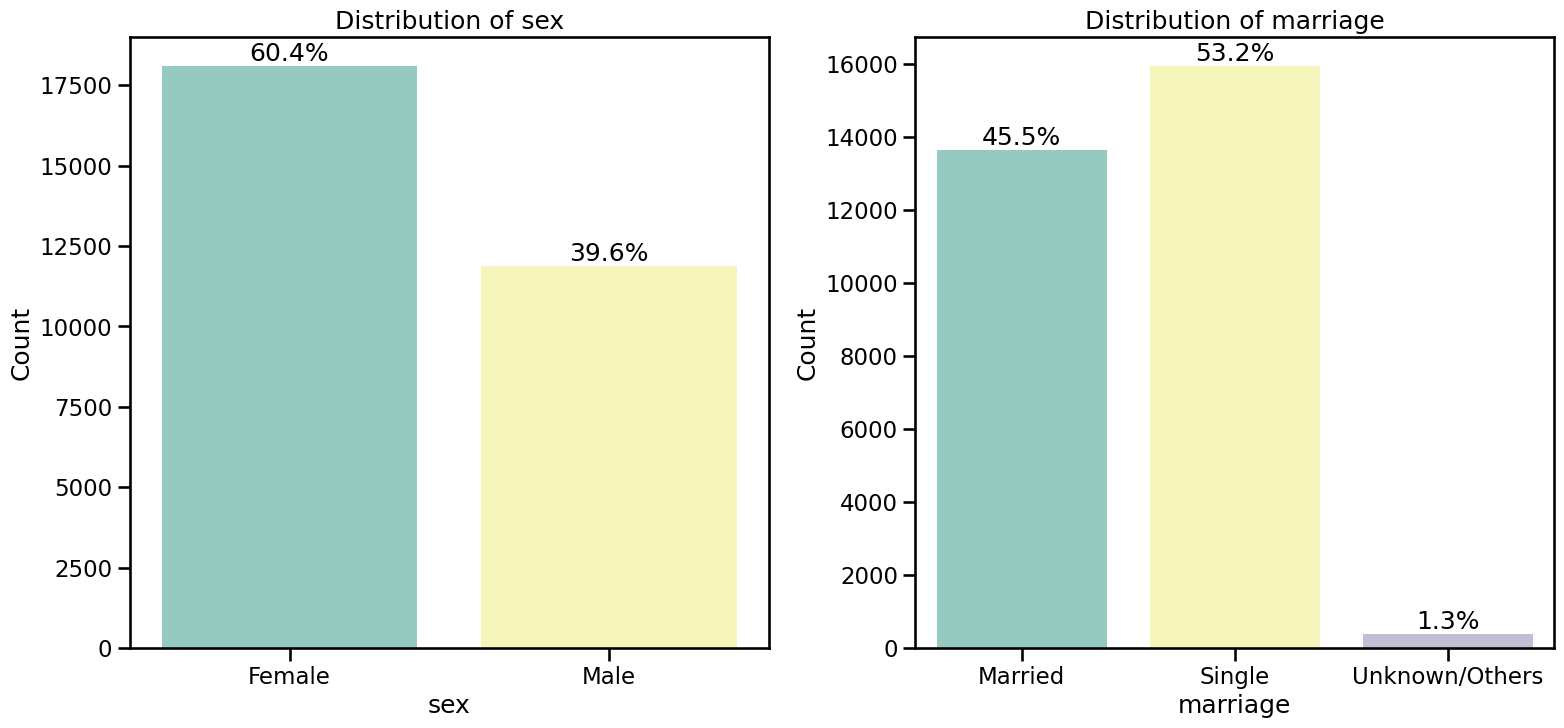

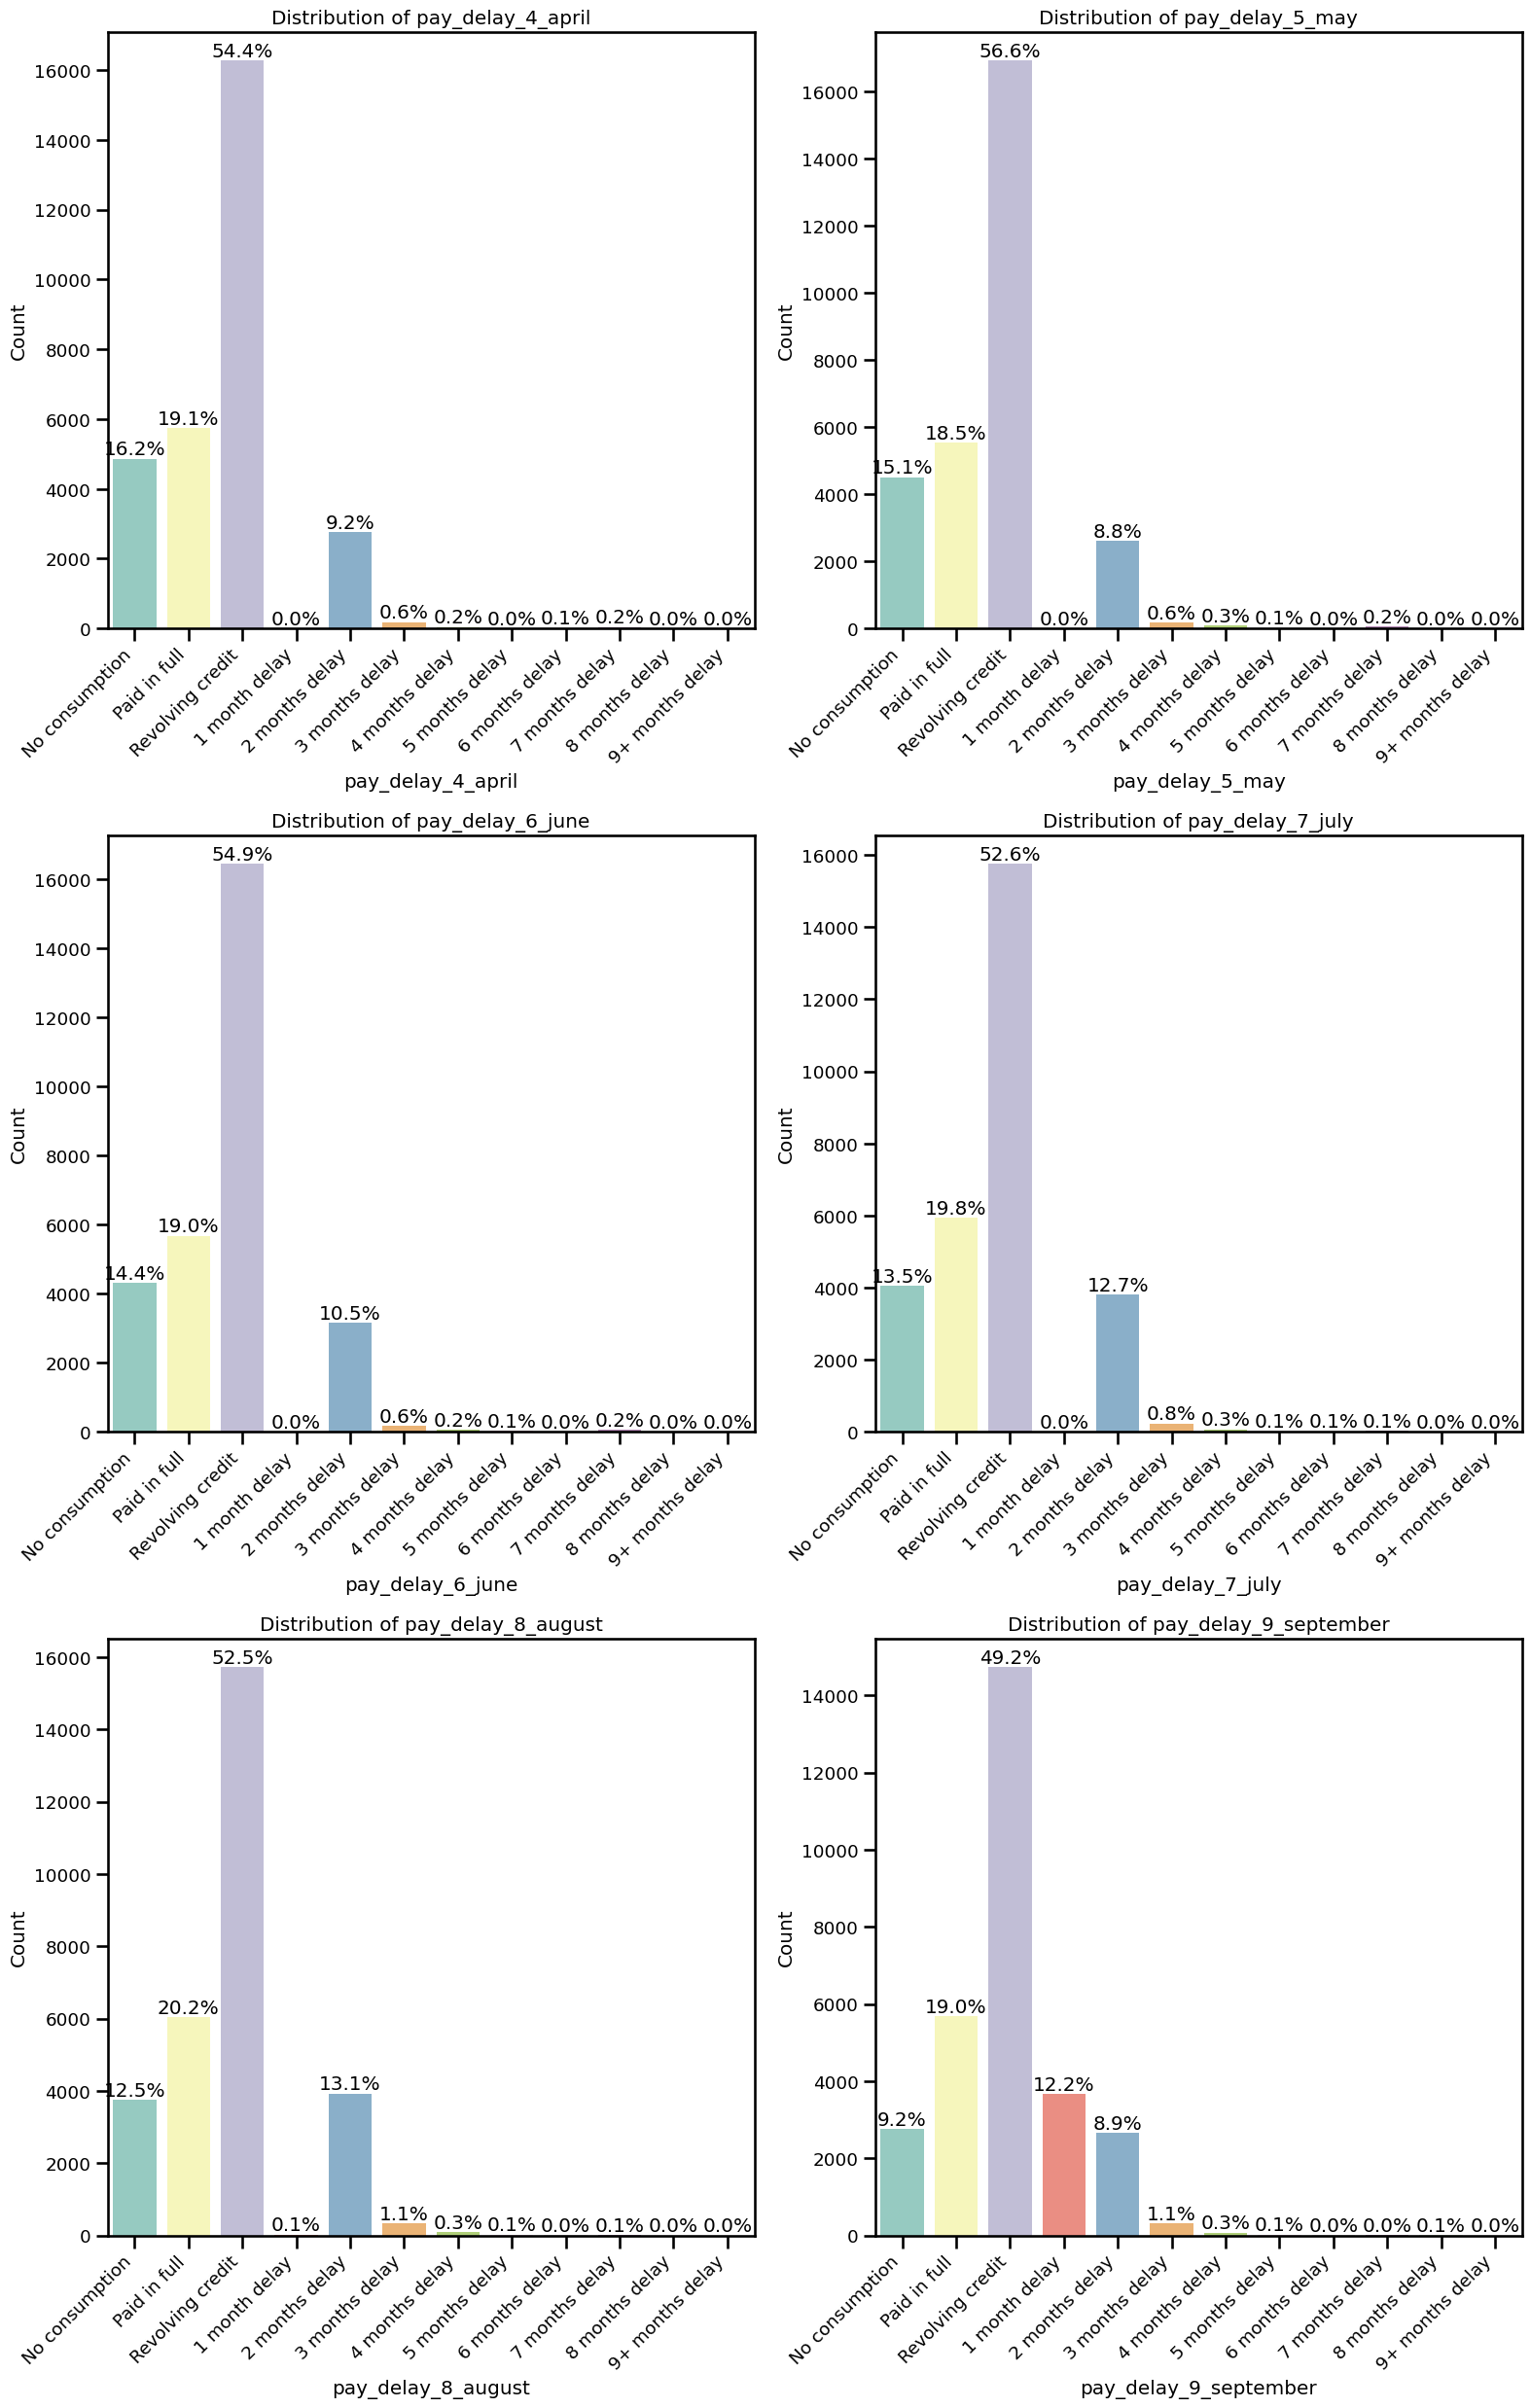

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from loan_data_utils import (load_data_from_url, clean_column_names, remove_id_column, rename_pay_columns, rename_bill_and_payment_columns,load_and_preprocess_data,
                             label_pay_columns, convert_pay_columns_to_ordinal, reorder_columns, convert_education_to_ordinal, process_sex_column, process_sex_column_cat_codes_one_two,
                             process_marriage_column, process_default_payment_column, convert_ordinal_to_category, check_column_integrity, validate_data_types,
                             check_categorical_order, primary_columns, bill_columns, pay_columns, ordinal_columns, categorical_columns,
                             plot_categorical_distributions, plot_ordinal_distributions)
from eda_utils import data_overview, plot_univariate_distributions, plot_class_distribution
import logging

# Define your URL, categorical columns, and target
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'marriage']
target = 'default_payment_next_month'

# Now, load the data
df = load_and_preprocess_data(url, categorical_columns, target)

if df is not None:
    # Ensure the target column is treated as a categorical variable
    # df[target] = df[target].astype('category')

    # Print data overview
    data_overview(df)

    # Drop duplicate rows (optional if you didn’t remove them earlier)
    df = df.drop_duplicates()

    # Confirm the duplicates are removed
    print(f"Number of Duplicate Rows After Dropping: {df.duplicated().sum()}")

    # List of columns to check
    pay_cols = [col for col in df.columns if col.startswith('pay_delay')]

    # Check the order of categorical columns
    check_categorical_order(df, categorical_columns + pay_cols + [target])
else:
    print("Error loading and preprocessing data.")

print('Target as numeric')
print(df['default_payment_next_month'].dtype)
print(df[target].value_counts())

# visualize the categorical data
plot_categorical_distributions(df, categorical_columns)
plot_ordinal_distributions(df, ordinal_columns)

### Feature Engineering Pipeline - Log Reg

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin

core_features = ['rolling_avg_delay', 'cumulative_delay']
rf_features = core_features + ['debt_to_limit_ratio','weighted_payment_sum', 'payment_std', 'avg_payment']
boolean_features = [ 'education_and_marriage_unknown_flag', 'education_or_marriage_unknown_flag']

# ------- Combined Feature Engineering Transformer for IMBPipeline -------#

class CombinedFeatureEngineeringTransformerLogReg(BaseEstimator, TransformerMixin):
    def __init__(self, delay_columns):
        self.delay_columns = delay_columns

    def fit(self, X, y=None):
        # This method doesn't need to do anything for this transformer
        return self

    def transform(self, X, y=None):
        """
        Apply only the necessary transformations for logistic regression.
        """
        # Apply transformations for the core features
        X = RollingAverageDelayTransformer(self.delay_columns).transform(X)
        X = CumulativeDelayTransformer(self.delay_columns).transform(X)
        X = EducationMarriageInteractionTransformer().transform(X)
        X = EducationMarriageUnknownFlagTransformer().transform(X)

        return X


In [20]:
# Import the necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline as IMBPipeline
from imblearn.over_sampling import SMOTE
from loan_data_utils import bill_columns, pay_columns, delay_columns, ordinal_columns, ThresholdClassifier
from feature_engineering_pipeline_utils import WinsorRobustOutlierRemovalTransformer, RollingAverageDelayTransformer, CumulativeDelayTransformer, EducationMarriageInteractionTransformer, EducationMarriageUnknownFlagTransformer

# Numeric Features (New numeric features added)
numeric_features_logreg = ['limit_bal', 'age', 'bill_amt_4_april', 'bill_amt_5_may', 'bill_amt_6_june',
                    'bill_amt_7_july', 'bill_amt_8_august', 'bill_amt_9_september', 'pay_amt_4_april',
                    'pay_amt_5_may', 'pay_amt_6_june', 'pay_amt_7_july', 'pay_amt_8_august', 'pay_amt_9_september'] + core_features
# Categorical Features
categorical_features = categorical_columns + ['education_marriage']
# Ordinal Features
ordinal_features = delay_columns + ['education']

# Define the target
target = 'default_payment_next_month'

# Split the data into features and target
X = df.drop(columns=[target])
y = df[target]

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Step 1: Feature Engineering and Preprocessing Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

bool_to_numeric_transformer = Pipeline(steps=[
    ('convert_bool', FunctionTransformer(lambda x: x.astype(int))),
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_logreg),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features),
        ('bool', bool_to_numeric_transformer, boolean_features)
    ]
)

# Step 1: Define the full pipeline (with SMOTE) for the training data
smote_preprocessing_pipeline = IMBPipeline(steps=[
    ('outlier_removal', WinsorRobustOutlierRemovalTransformer(columns=pay_columns)),  # Outlier removal
    ('feature_engineering', CombinedFeatureEngineeringTransformerLogReg(delay_columns)),  # Feature engineering
    ('preprocessor', preprocessor),  # Preprocessing
    ('smote', SMOTE())  # SMOTE for resampling
])

# Step 2: Define the preprocessing pipeline for the test data (without SMOTE)
test_preprocessing_pipeline = Pipeline(steps=[
    ('outlier_removal', WinsorRobustOutlierRemovalTransformer(columns=pay_columns)),  # Outlier removal
    # Reuse the fitted CombinedFeatureEngineeringTransformer from the training pipeline
    ('feature_engineering', smote_preprocessing_pipeline.named_steps['feature_engineering']),
    ('preprocessor', preprocessor)  # Preprocessing (without SMOTE)
])

# Step 3: Fit the training pipeline and resample the training data
X_train_processed, y_train_resampled = smote_preprocessing_pipeline.fit_resample(X_train, y_train)

# Step 4: Fit the test preprocessing pipeline using the training data
# Ensuring the test pipeline learns from X_train for scaling and encoding
test_preprocessing_pipeline.fit(X_train)

# Step 5: Transform the test data using the test preprocessing pipeline
X_test_processed = test_preprocessing_pipeline.transform(X_test)

# Initialize an empty list to store feature names
all_feature_names = []

# Loop through each transformer in the preprocessor to capture feature names
for name, transformer, columns in smote_preprocessing_pipeline.named_steps['preprocessor'].transformers_:
    if name == 'num':  # Numeric features (imputation and scaling)
        all_feature_names.extend(transformer.named_steps['scaler'].get_feature_names_out(columns))
    elif name == 'cat':  # Categorical features (OneHotEncoder)
        all_feature_names.extend(transformer.named_steps['onehot'].get_feature_names_out(columns))
    elif name == 'ord':  # Ordinal features (OrdinalEncoder)
        all_feature_names.extend(columns)  # Ordinal features don't expand, so just use the column names
    elif name == 'bool':  # Boolean features (converted to int)
        all_feature_names.extend(columns)

# Step 7: Convert the processed training and test data to DataFrames with meaningful feature names
X_train_processed_df = pd.DataFrame(X_train_processed, columns=all_feature_names)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=all_feature_names)

# Step 8: Add the target variable to the training and test DataFrames
X_train_processed_df['target'] = y_train_resampled.reset_index(drop=True)
X_test_processed_df['target'] = y_test.reset_index(drop=True)  # We don't resample y_test

# Step 9: Inspect the processed DataFrames (Optional step)
print("Processed training data:")
print(X_train_processed_df.info())
print("Processed test data:")
print(X_test_processed_df.info())

Processed training data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37336 entries, 0 to 37335
Data columns (total 43 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   limit_bal                                          37336 non-null  float64
 1   age                                                37336 non-null  float64
 2   bill_amt_4_april                                   37336 non-null  float64
 3   bill_amt_5_may                                     37336 non-null  float64
 4   bill_amt_6_june                                    37336 non-null  float64
 5   bill_amt_7_july                                    37336 non-null  float64
 6   bill_amt_8_august                                  37336 non-null  float64
 7   bill_amt_9_september                               37336 non-null  float64
 8   pay_amt_4_april                                    37336 non-

### Predict with Selected Features

In [10]:
import json
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Step 6: Fit the Logistic Regression model on the processed training data
logreg_model = LogisticRegression(max_iter=3000, random_state=42)
logreg_model.fit(X_train_processed, y_train_resampled)

# Step 7: Use the model to predict on the processed test data
y_pred_logreg = logreg_model.predict(X_test_processed)

# Step 8: Generate the classification report
classification_report_logreg = classification_report(y_test, y_pred_logreg, output_dict=True)
print("Classification Report (Logistic Regression Baseline):")
print(classification_report(y_test, y_pred_logreg, output_dict=False))

# Step 9: Save the classification report to a JSON file
output_filename = 'classification_reports_logreg.json'
try:
    # Load existing reports if the file already exists
    with open(output_filename, 'r') as file:
        results = json.load(file)
except FileNotFoundError:
    # If the file doesn't exist, create a new dictionary
    results = {}

# Add the new report under the "logreg_baseline" key
results['logreg_baseline'] = classification_report_logreg

# Save the updated results back to the JSON file
with open(output_filename, 'w') as file:
    json.dump(results, file, indent=4)

print(f"Classification report saved to {output_filename}")


Classification Report (Logistic Regression Baseline):
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      4667
           1       0.47      0.58      0.52      1326

    accuracy                           0.76      5993
   macro avg       0.67      0.70      0.68      5993
weighted avg       0.78      0.76      0.77      5993

Classification report saved to classification_reports_logreg.json


### Threshold Classifier - Optimal Search

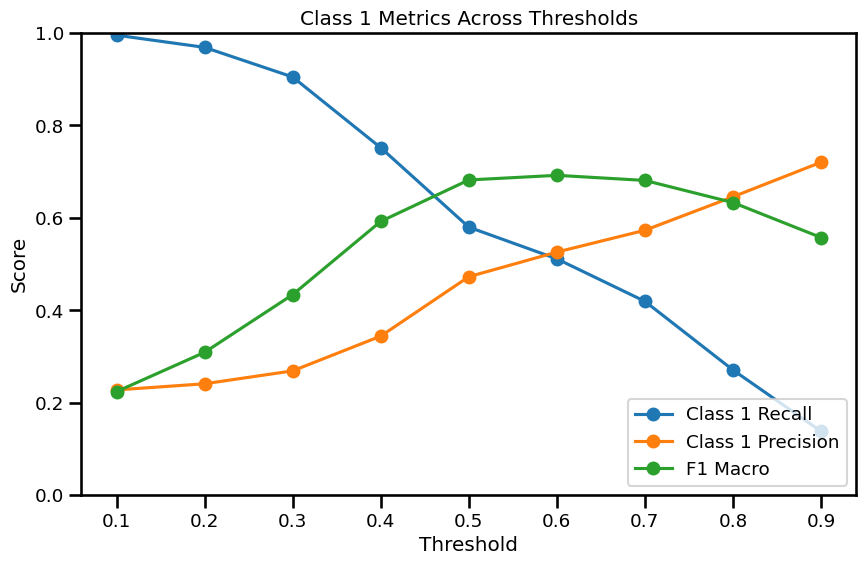

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np

# Define a range of thresholds to test
threshold_values = np.arange(0.1, 1.0, 0.1)

# Lists to store metrics for plotting
recall_scores = []
precision_scores = []
f1_macro_scores = []

# Step 1: Create and fit the logistic regression model
log_reg = LogisticRegression(max_iter=3000)
log_reg.fit(X_train_processed_df.drop(columns=['target']), y_train_resampled)

# Step 2: Predict probabilities for the positive class (class 1) on the test set
y_prob = log_reg.predict_proba(X_test_processed_df.drop(columns=['target']))[:, 1]

# Step 3: Iterate through each threshold value
for threshold in threshold_values:
    # print(f"Testing threshold: {threshold}")

    # Apply the threshold to generate predictions
    y_pred = (y_prob >= threshold).astype(int)

    # Generate the classification report
    report = classification_report(X_test_processed_df['target'], y_pred, output_dict=True)

    # Store metrics for the current threshold
    recall_scores.append(report['1']['recall'])
    precision_scores.append(report['1']['precision'])
    f1_macro_scores.append(report['macro avg']['f1-score'])

# After the loop, print the metrics for each threshold
# print("Thresholds:", threshold_values)
# print("Recall scores:", recall_scores)
# print("Precision scores:", precision_scores)
# print("F1-macro scores:", f1_macro_scores)

# Plotting the metrics
plt.figure(figsize=(10, 6))
plt.plot(threshold_values, recall_scores, label="Class 1 Recall", marker='o')
plt.plot(threshold_values, precision_scores, label="Class 1 Precision", marker='o')
plt.plot(threshold_values, f1_macro_scores, label="F1 Macro", marker='o')

# Plot labels and title
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Class 1 Metrics Across Thresholds")
plt.ylim(0, 1)
plt.legend(loc='lower right')

# Show the plot
plt.show()

### Predict with Optimal Threshold

In [25]:
# Create the logistic regression model
log_reg = LogisticRegression(max_iter=3000)

# Wrap the model with ThresholdClassifier using the custom threshold
threshold_classifier = ThresholdClassifier(base_classifier=log_reg, threshold=0.4)

# Train the threshold classifier using preprocessed training data
threshold_classifier.fit(X_train_processed_df.drop(columns=['target']), y_train_resampled)

# Predict using the threshold classifier on the preprocessed test data
y_pred_threshold = threshold_classifier.predict(X_test_processed_df.drop(columns=['target']))

# Generate the classification report
classification_report_threshold = classification_report(X_test_processed_df['target'], y_pred_threshold, output_dict=True)
print("Classification Report (Logistic Regression with Custom Threshold):")
print(classification_report(X_test_processed_df['target'], y_pred_threshold))

# Save the classification report to a JSON file
output_filename = 'classification_reports_logreg.json'
try:
    # Load existing reports if the file already exists
    with open(output_filename, 'r') as file:
        results = json.load(file)
except FileNotFoundError:
    # If the file doesn't exist, create a new dictionary
    results = {}

# Add the new report under a new key
results['logreg_with_threshold_0.4'] = classification_report_threshold

# Save the updated results back to the JSON file
with open(output_filename, 'w') as file:
    json.dump(results, file, indent=4)

print(f"Classification report saved to {output_filename}")


Classification Report (Logistic Regression with Custom Threshold):
              precision    recall  f1-score   support

           0       0.89      0.59      0.71      4667
           1       0.34      0.75      0.47      1326

    accuracy                           0.63      5993
   macro avg       0.62      0.67      0.59      5993
weighted avg       0.77      0.63      0.66      5993

Classification report saved to classification_reports_logreg.json


### Grid Search for Optimal Model Performance

In [27]:
from sklearn.model_selection import GridSearchCV

# Define the logistic regression model
log_reg = LogisticRegression(max_iter=1000)

# Set up the hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l2', 'l1']
}

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, scoring='recall', cv=5, n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train_processed_df.drop(columns=['target']), y_train_resampled)

# Get the best parameters
print(f"Best parameters: {grid_search.best_params_}")


Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


### Predict with Optimal Params

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import json

# Create the logistic regression model with the optimal hyperparameters
log_reg = LogisticRegression(max_iter=3000, C=10, penalty='l2', solver='liblinear')

# Wrap the model with ThresholdClassifier using the custom threshold
threshold_classifier = ThresholdClassifier(base_classifier=log_reg, threshold=0.4)

# Train the threshold classifier using preprocessed training data
threshold_classifier.fit(X_train_processed_df.drop(columns=['target']), y_train_resampled)

# Predict using the threshold classifier on the preprocessed test data
y_pred_threshold = threshold_classifier.predict(X_test_processed_df.drop(columns=['target']))

# Generate the classification report
classification_report_threshold = classification_report(X_test_processed_df['target'], y_pred_threshold, output_dict=True)
print("Classification Report (Optimal Logistic Regression with Custom Threshold):")
print(classification_report(X_test_processed_df['target'], y_pred_threshold))

# Save the classification report to a JSON file
output_filename = 'classification_reports_logreg.json'
try:
    # Load existing reports if the file already exists
    with open(output_filename, 'r') as file:
        results = json.load(file)
except FileNotFoundError:
    # If the file doesn't exist, create a new dictionary
    results = {}

# Add the new report under a new key
results['logreg_optimal'] = classification_report_threshold

# Save the updated results back to the JSON file
with open(output_filename, 'w') as file:
    json.dump(results, file, indent=4)

print(f"Classification report saved to {output_filename}")

Classification Report (Optimal Logistic Regression with Custom Threshold):
              precision    recall  f1-score   support

           0       0.89      0.59      0.71      4667
           1       0.34      0.75      0.47      1326

    accuracy                           0.63      5993
   macro avg       0.62      0.67      0.59      5993
weighted avg       0.77      0.63      0.66      5993

Classification report saved to classification_reports_logreg.json


#### Plot Model Comparisons

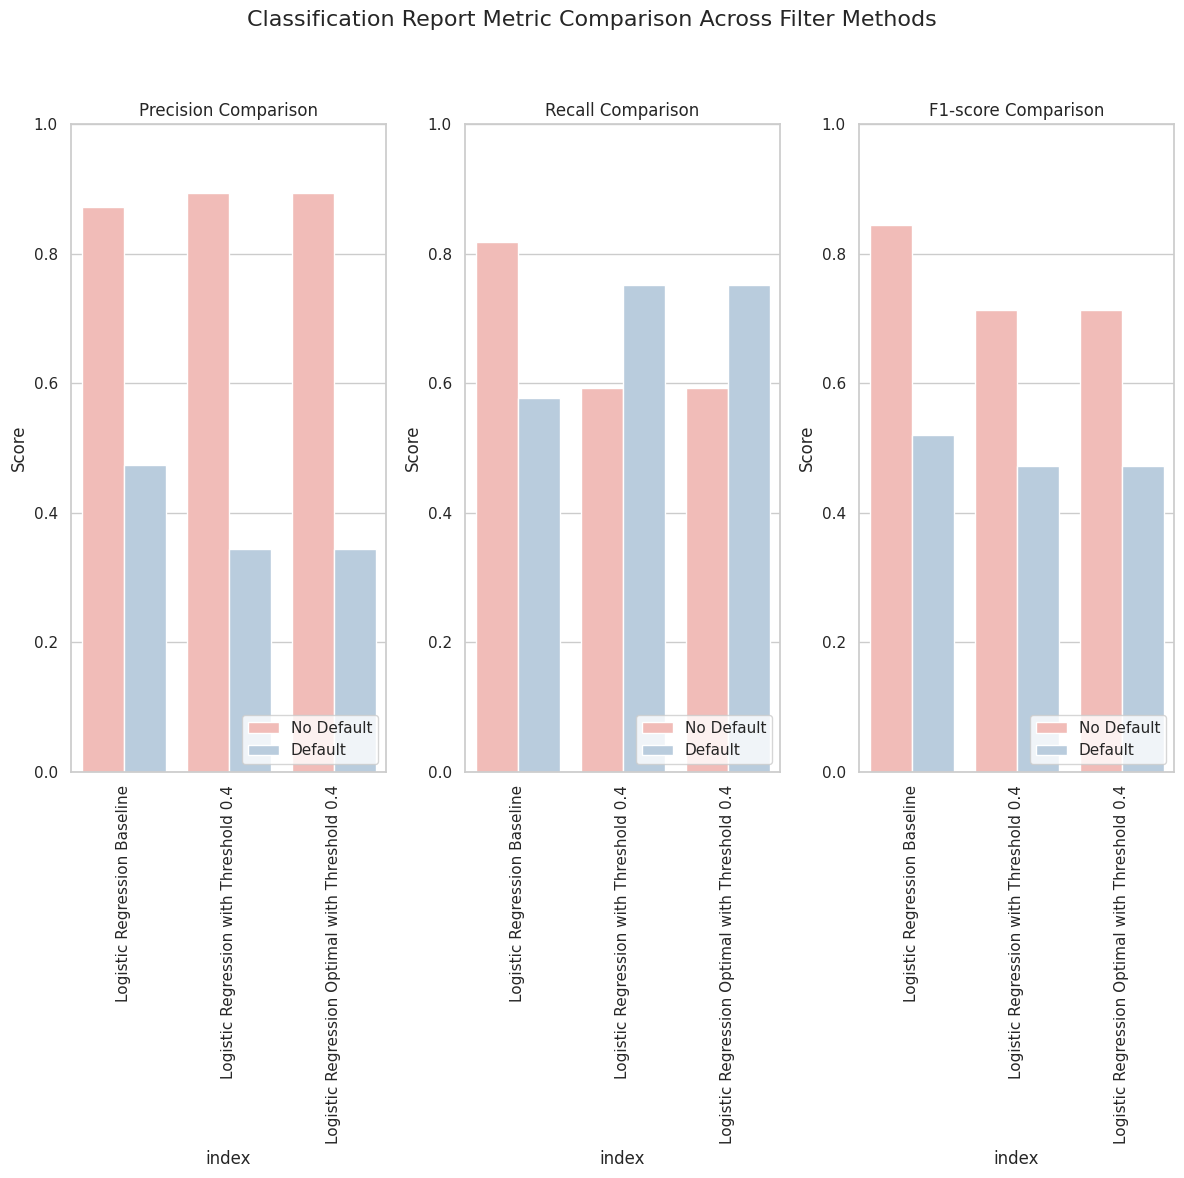

In [36]:
from feature_selection_utils import plot_comparison_classification_metrics_seaborn
import json
import seaborn as sns

# Step 1: Load the classification reports from the JSON file
with open('classification_reports_logreg.json', 'r') as json_file:
    results = json.load(json_file)

# Set the seaborn theme and style for better aesthetics
sns.set_theme(style="whitegrid", context='notebook', palette="Pastel1")

# Collect classification reports for the logistic regression runs
classification_reports = [
    results['logreg_baseline'],
    results['logreg_with_threshold_0.4'],
    results['logreg_optimal']
]

# Update model names to match the models used
model_names = [
    'Logistic Regression Baseline',
    'Logistic Regression with Threshold 0.4',
    'Logistic Regression Optimal with Threshold 0.4'
]

# Plot the comparison of classification metrics across all logistic regression runs
plot_comparison_classification_metrics_seaborn(classification_reports, model_names)


#### Plot Metrics by Model

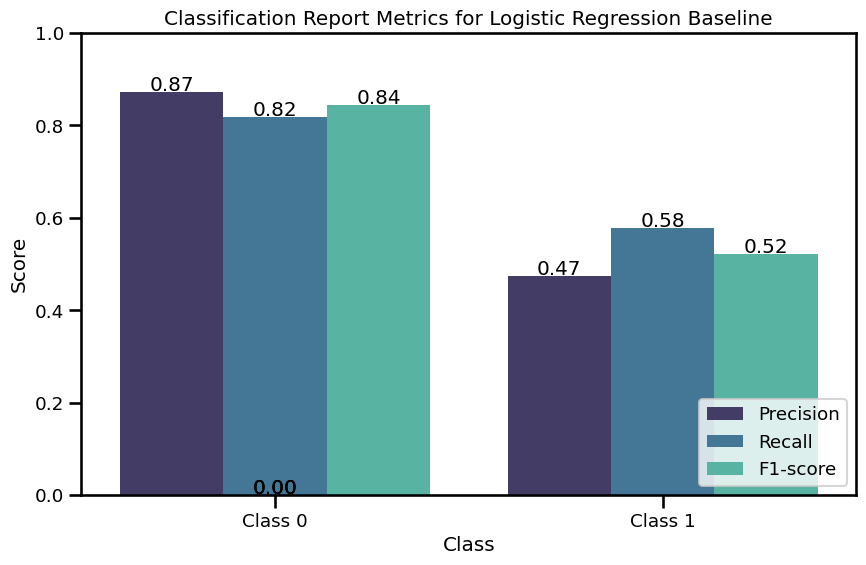

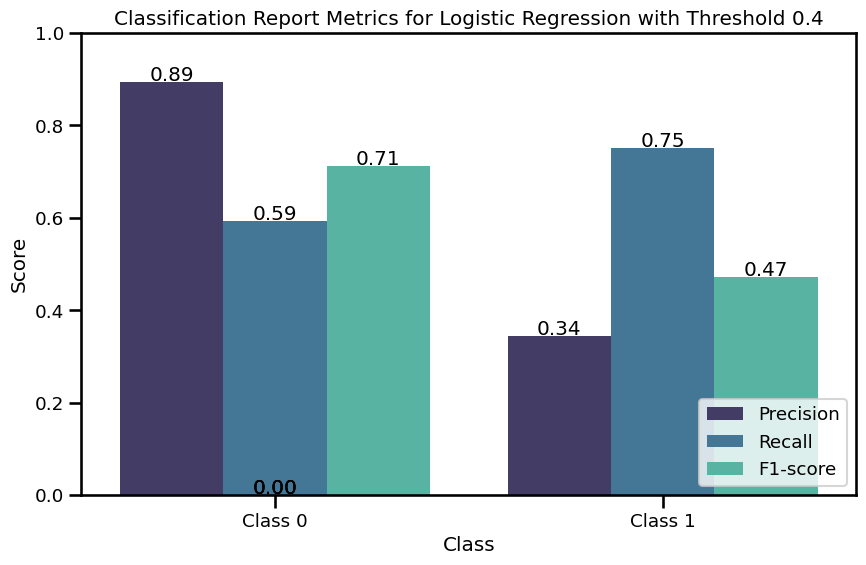

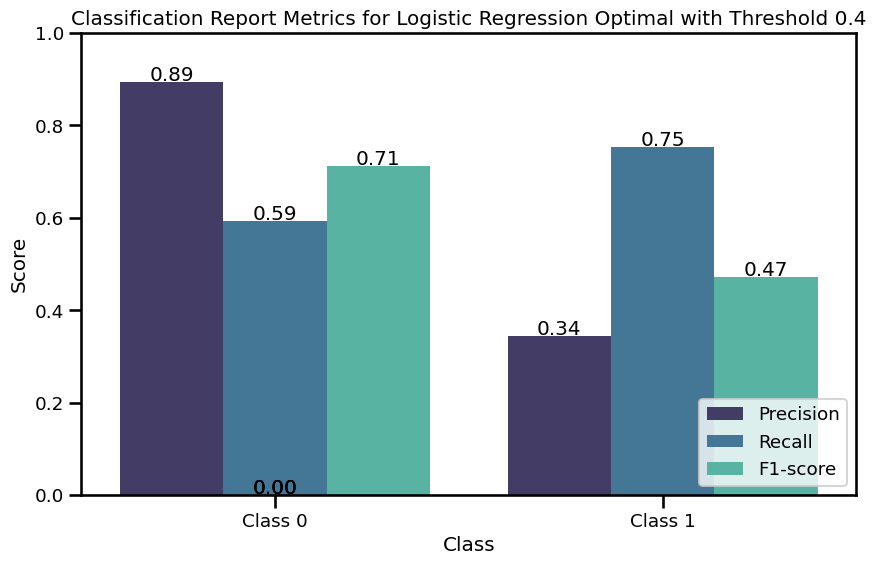

In [30]:
from loan_data_utils import plot_classification_report_metrics
import json

# Step 1: Load the classification reports from the JSON file
with open('classification_reports_logreg.json', 'r') as json_file:
    classification_reports = json.load(json_file)

# Step 2: Plot the metrics for the baseline model
plot_classification_report_metrics(classification_reports['logreg_baseline'], 'Logistic Regression Baseline')

# Step 3: Plot the metrics for the SMOTE-enhanced model with threshold 0.4
plot_classification_report_metrics(classification_reports['logreg_with_threshold_0.4'], 'Logistic Regression with Threshold 0.4')

# Step 4: Plot the metrics for the optimal SMOTE model with threshold 0.4
plot_classification_report_metrics(classification_reports['logreg_optimal'], 'Logistic Regression Optimal with Threshold 0.4')


#### Loan Data Utils

In [1]:
script_content=r'''
# loan_data_utils.py

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin

import json

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define constants
target = 'default_payment_next_month'

# ------  Define columns  --------- #

# column lists from loan data utils
primary_columns = ['limit_bal', 'sex', 'education', 'marriage', 'age']
bill_columns = ['bill_amt_4_april', 'bill_amt_5_may', 'bill_amt_6_june', 'bill_amt_7_july', 'bill_amt_8_august', 'bill_amt_9_september']
pay_columns = ['pay_amt_4_april', 'pay_amt_5_may', 'pay_amt_6_june', 'pay_amt_7_july', 'pay_amt_8_august', 'pay_amt_9_september']
delay_columns = ['pay_delay_4_april', 'pay_delay_5_may', 'pay_delay_6_june','pay_delay_7_july', 'pay_delay_8_august', 'pay_delay_9_september']
categorical_columns = ['sex', 'marriage']
ordinal_columns = delay_columns + ['education']

# ---------  Load Data  --------- #

def load_data_from_url(url):
    try:
        df = pd.read_excel(url, header=1)
        logging.info("Data loaded successfully from URL.")
    except Exception as e:
        logging.error(f"Error loading data from URL: {e}")
        return None
    return df

def split_features_target(df, target):
    try:
        X = df.drop(columns=[target])
        y = df[target]
        logging.info("Features and target split successfully.")
    except Exception as e:
        logging.error(f"Error splitting features and target: {e}")
        return None, None
    return X, y


def clean_column_names(df):
    try:
        df.columns = [col.lower().replace(' ', '_') for col in df.columns]
        logging.info("Column names cleaned successfully.")
    except Exception as e:
        logging.error(f"Error cleaning column names: {e}")
    return df

def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
        logging.info("ID column removed.")
    return df

# ---------  Sex Column Processing  --------- #
# ---- SEX: Gender (1 = male, 2 = female) ----#

# results in cat.categories = ['Female', 'Male'][0,1]
def process_sex_column(df):
    try:
        if 'sex' in df.columns:
            df['sex'] = df['sex'].replace({1: 'Male', 2: 'Female'})
            df['sex'] = df['sex'].astype('category')
            logging.info("Sex column processed and converted to categorical successfully.")
        else:
            logging.warning("Sex column not found in DataFrame.")
    except Exception as e:
        logging.error(f"Error processing sex column: {e}")
    return df

# results in cat.categories = ['Female', 'Male'][2,1] (alphabetically ordered)
def process_sex_column_cat_codes_one_two(df):
    try:
        if 'sex' in df.columns:
            # Convert numeric values to categorical, maintaining original codes
            df['sex'] = df['sex'].astype('category')  # First, ensure the column is categorical

            # Define the categories explicitly and map original values (1: Male, 2: Female)
            df['sex'].cat.set_categories([1, 2], rename=True, inplace=True)  # Set categories as 1, 2
            df['sex'] = df['sex'].replace({1: 'Male', 2: 'Female'})  # Replace numeric values with labels

            logging.info("Sex column processed and converted to categorical successfully.")
        else:
            logging.warning("Sex column not found in DataFrame.")
    except Exception as e:
        logging.error(f"Error processing sex column: {e}")
    return df

# ---------  Marriage Column Processing  --------- #

# ---- MARRIAGE: Marital status (1 = married, 2 = single, 3 = other) ----#

def process_marriage_column(df):
    try:
        if 'marriage' in df.columns:
            df['marriage'] = df['marriage'].replace({0: 'Unknown/Others', 3: 'Unknown/Others'})
            df['marriage'] = df['marriage'].replace({1: 'Married', 2: 'Single'})
            df['marriage'] = pd.Categorical(df['marriage'], categories=['Married', 'Single', 'Unknown/Others'], ordered=False)
            logging.info("Marriage column processed and converted to categorical successfully.")
        else:
            logging.warning("Marriage column not found in DataFrame.")
    except Exception as e:
        logging.error(f"Error processing marriage column: {e}")
    return df

# ---------  Target Column Processing  --------- #

def process_default_payment_column(df):
    try:
        if 'default_payment_next_month' in df.columns:
            # Label the categories
            df['default_payment_next_month'] = df['default_payment_next_month'].replace({0: 'No Default', 1: 'Default'})
            df['default_payment_next_month'] = df['default_payment_next_month'].astype('category')
            logging.info("Default payment column labeled and converted to categorical successfully.")
        else:
            logging.warning("Default payment column not found in DataFrame.")
    except Exception as e:
        logging.error(f"Error processing default payment column: {e}")
    return df


# Convert labels to numeric for modeling
def convert_default_payment_to_numeric(df):
    try:
        if 'default_payment_next_month' in df.columns:
            df['default_payment_next_month'] = df['default_payment_next_month'].replace({'No Default': 0, 'Default': 1}).astype(int)
            logging.info("Default payment column converted back to numeric for modeling.")
        else:
            logging.warning("Default payment column not found in DataFrame.")
    except Exception as e:
        logging.error(f"Error converting default payment column to numeric: {e}")
    return df

# ---------  Pay Delay Column Processing  --------- #

def rename_pay_columns(df):
    try:
        # Only rename if the original columns exist
        if all(col in df.columns for col in ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']):
            pay_columns_new_names = {
                'pay_0': 'pay_delay_9_september',
                'pay_2': 'pay_delay_8_august',
                'pay_3': 'pay_delay_7_july',
                'pay_4': 'pay_delay_6_june',
                'pay_5': 'pay_delay_5_may',
                'pay_6': 'pay_delay_4_april'
            }
            df = df.rename(columns=pay_columns_new_names)
            logging.info("Pay delay columns renamed successfully.")
        else:
            logging.warning("Some or all of the expected pay columns are missing. Renaming skipped.")
    except Exception as e:
        logging.error(f"Error renaming pay delay columns: {e}")
    return df

def rename_bill_and_payment_columns(df):
    try:
        # Correct renaming of bill_amt and pay_amt columns
        bill_amt_new_names = {
            'bill_amt1': 'bill_amt_9_september',
            'bill_amt2': 'bill_amt_8_august',
            'bill_amt3': 'bill_amt_7_july',
            'bill_amt4': 'bill_amt_6_june',
            'bill_amt5': 'bill_amt_5_may',
            'bill_amt6': 'bill_amt_4_april'
        }

        pay_amt_new_names = {
            'pay_amt1': 'pay_amt_9_september',
            'pay_amt2': 'pay_amt_8_august',
            'pay_amt3': 'pay_amt_7_july',
            'pay_amt4': 'pay_amt_6_june',
            'pay_amt5': 'pay_amt_5_may',
            'pay_amt6': 'pay_amt_4_april'
        }

        df = df.rename(columns={**bill_amt_new_names, **pay_amt_new_names})
        logging.info("Bill and payment columns renamed successfully.")
    except Exception as e:
        logging.error(f"Error renaming bill and payment columns: {e}")
    return df


def label_pay_columns(df, pay_columns):
    try:
        # Only label the pay_delay_* columns, not pay_amt_*
        pay_labels = {
            -2: "No consumption",
            -1: "Paid in full",
            0: "Revolving credit",
            1: "1 month delay",
            2: "2 months delay",
            3: "3 months delay",
            4: "4 months delay",
            5: "5 months delay",
            6: "6 months delay",
            7: "7 months delay",
            8: "8 months delay",
            9: "9+ months delay"
        }

        for col in pay_columns:
            # Ensure we're only mapping the delay columns and not payment amount columns
            if 'pay_delay' in col and col in df.columns:
                df[col] = df[col].map(pay_labels)
                logging.info(f"Column {col} labeled successfully.")
            else:
                logging.error(f"Column {col} not found in DataFrame.")

    except Exception as e:
        logging.error(f"Error labeling pay columns: {e}")
    return df

def convert_pay_columns_to_ordinal(df, pay_columns):
    try:
        pay_order = [
            "No consumption",  # -2
            "Paid in full",    # -1
            "Revolving credit", # 0
            "1 month delay",   # 1
            "2 months delay",  # 2
            "3 months delay",  # 3
            "4 months delay",  # 4
            "5 months delay",  # 5
            "6 months delay",  # 6
            "7 months delay",  # 7
            "8 months delay",  # 8
            "9+ months delay"  # 9
        ]

        for col in pay_columns:
            # Ensure only delay columns are converted to categorical
            if 'pay_delay' in col and col in df.columns:
                df[col] = pd.Categorical(df[col], categories=pay_order, ordered=True)
                logging.info(f"Column {col} converted to ordinal successfully.")
            else:
                logging.error(f"Column {col} not found in DataFrame.")

    except Exception as e:
        logging.error(f"Error converting pay columns to ordinal categories: {e}")
    return df


def convert_ordinal_to_category(df, ordinal_columns):
    try:
        for col in ordinal_columns:
            if col in df.columns:
                df[col] = df[col].astype('category')
                logging.info(f"Column {col} converted to category successfully.")
            else:
                logging.error(f"Column {col} not found in DataFrame.")
    except Exception as e:
        logging.error(f"Error converting ordinal columns to category: {e}")
    return df

# ---------  Education Column Processing  --------- #

def convert_education_to_ordinal(df):
    try:
        # Explicitly map all values to handle known categories
        education_mapping = {
            1: 'Graduate School',
            2: 'University',
            3: 'High School',
            4: 'Other/Unknown',
            5: 'Other/Unknown',
            6: 'Other/Unknown',
            0: 'Other/Unknown'  # Handle the 0 value as well
        }

        df['education'] = df['education'].replace(education_mapping)

        # Define the order of education categories
        education_order = [
            "Other/Unknown",    # Grouped 0, 4, 5, 6 together
            "High School",      # 3
            "University",       # 2
            "Graduate School"   # 1
        ]

        if 'education' in df.columns:
            # Convert the education column to a categorical type with the specified order
            df['education'] = pd.Categorical(df['education'], categories=education_order, ordered=True)
            logging.info("Education column converted to ordinal categories successfully.")
        else:
            logging.error("Education column not found in DataFrame.")
    except Exception as e:
        logging.error(f"Error converting education column to ordinal categories: {e}")
    return df


#-------- Utility and validation functions first ----------#

def check_column_integrity(df, expected_columns):
    missing_columns = [col for col in expected_columns if col not in df.columns]
    if missing_columns:
        logging.error(f"Missing columns: {missing_columns}")
    else:
        logging.info("All expected columns are present.")

def validate_data_types(df, ordinal_columns):
    for col in ordinal_columns:
        if col in df.columns:
            if not pd.api.types.is_categorical_dtype(df[col]):
                logging.warning(f"Column {col} is not correctly set as categorical.")
            else:
                logging.info(f"Column {col} is correctly set as categorical with the following categories: {df[col].cat.categories}")
        else:
            logging.error(f"Column {col} not found in DataFrame.")
    logging.info("Data type validation complete.")

def reorder_columns(df):
    try:
        # Define the order of the pay_delay columns in chronological order
        pay_delay_order = [
            'pay_delay_4_april',
            'pay_delay_5_may',
            'pay_delay_6_june',
            'pay_delay_7_july',
            'pay_delay_8_august',
            'pay_delay_9_september'
        ]

        # Combine primary, bill, pay, and pay_delay columns with other columns
        other_columns = [col for col in df.columns if col not in primary_columns + bill_columns + pay_columns + pay_delay_order]
        df = df[primary_columns + bill_columns + pay_columns + pay_delay_order + other_columns]
        logging.info("Columns reordered successfully.")
    except Exception as e:
        logging.error(f"Error reordering columns: {e}")
    return df


#--------  Load and Preprocess Data  --------- #

def load_and_preprocess_data(url, categorical_columns, target):
    df = load_data_from_url(url)
    if df is not None:
        try:
            # Include the target column from the start
            df = clean_column_names(df)
            df = remove_id_column(df)
            df = rename_pay_columns(df)
            df = rename_bill_and_payment_columns(df)
            df = label_pay_columns(df, [col for col in df.columns if 'pay_delay' in col])
            df = convert_pay_columns_to_ordinal(df, [col for col in df.columns if 'pay_delay' in col])
            df = reorder_columns(df)
            df = convert_education_to_ordinal(df)
            df = process_sex_column(df)
            # df = process_sex_column_cat_codes_one_two(df)
            df = process_marriage_column(df)
            # df = process_default_payment_column(df) # leave as numeric for modeling
            df = convert_ordinal_to_category(df, ordinal_columns)

            # Run validation checks
            check_column_integrity(df, primary_columns + bill_columns + pay_columns + ordinal_columns)
            validate_data_types(df, ordinal_columns)

            # Drop duplicates consistently across both features and target
            df = df.drop_duplicates()

            logging.info("Data loaded and preprocessed successfully.")
            return df
        except Exception as e:
            logging.error(f"Error in data preprocessing: {e}")
            return None
    return None

#--------  Load Preprocess Split Data  --------- #

def load_preprocess_split_data(url, categorical_columns, target):
    df = load_data_from_url(url)
    if df is not None:
        try:
            df = clean_column_names(df)
            df = remove_id_column(df)
            df = rename_pay_columns(df)
            df = rename_bill_and_payment_columns(df)
            df = label_pay_columns(df, [col for col in df.columns if 'pay_delay' in col])
            df = convert_pay_columns_to_ordinal(df, [col for col in df.columns if 'pay_delay' in col])
            df = reorder_columns(df)
            df = convert_education_to_ordinal(df)
            df = process_sex_column(df)  # Process the sex column separately
            df = process_marriage_column(df)  # Process the marriage column separately
            df = convert_ordinal_to_category(df, ordinal_columns)

            # Run validation checks
            check_column_integrity(df, primary_columns + bill_columns + pay_columns + ordinal_columns)
            validate_data_types(df, ordinal_columns)

            X, y = split_features_target(df, target)
            logging.info("Data loaded and preprocessed successfully.")
            return X, y
        except Exception as e:
            logging.error(f"Error in data preprocessing: {e}")
            return None, None
    return None, None


def check_categorical_order(df, columns):
    for col in columns:
        if pd.api.types.is_categorical_dtype(df[col]):
            print(f"Column: {col}")
            print(f"Categories: {df[col].cat.categories}")
            print(f"Ordered: {df[col].cat.ordered}\n")
        else:
            print(f"Column: {col} is not categorical.\n")

#--------  Plot Categorical Data Functions  --------- #


def plot_categorical_distributions(df, categorical_columns):
    """Function to plot categorical distributions."""
    plt.figure(figsize=(16, 14))
    sns.set_context('talk')
    for i, column in enumerate(categorical_columns, 1):
        plt.subplot(2, 2, i)
        sns.countplot(data=df, x=column, hue=column, palette='Set3', legend=False)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')

        # Add percentage annotations
        total = len(df)
        for p in plt.gca().patches:
            percentage = 100 * p.get_height() / total
            plt.gca().text(p.get_x() + p.get_width() / 2, p.get_height(),
                           f'{percentage:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

ord_cols = [
    'pay_delay_4_april', 'pay_delay_5_may', 'pay_delay_6_june',
    'pay_delay_7_july', 'pay_delay_8_august', 'pay_delay_9_september'
]

def plot_ordinal_distributions(df, ordinal_columns):
    """Function to plot ordinal distributions using barplot with hue."""
    plt.figure(figsize=(16, 25))
    sns.set_context('talk', font_scale=0.8)
    for i, column in enumerate(ord_cols, 1):
        plt.subplot(3, 2, i)

        # Get the counts for each category
        category_counts = df[column].value_counts().sort_index()

        sns.barplot(x=category_counts.index, y=category_counts.values, hue=category_counts.index, palette='Set3')

        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')

        # Rotate x-tick labels for better legibility
        plt.xticks(rotation=45, ha='right')

        # Add percentage annotations
        total = len(df)
        for p in plt.gca().patches:
            percentage = 100 * p.get_height() / total
            plt.gca().text(p.get_x() + p.get_width() / 2, p.get_height(),
                           f'{percentage:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


# --------- Custom Transformer for Threshold Classifier --------- #

class ThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_classifier=None, threshold=0.5):
        # Default to LogisticRegression if no classifier is provided
        self.base_classifier = base_classifier if base_classifier is not None else LogisticRegression(max_iter=1000)
        self.threshold = threshold

    def fit(self, X, y):
        # Fit the base classifier on the training data
        self.base_classifier.fit(X, y)
        return self

    def predict(self, X):
        # Get the predicted probabilities for class 1 (positive class)
        probas = self.base_classifier.predict_proba(X)[:, 1]
        # Apply the threshold to make class predictions
        return (probas >= self.threshold).astype(int)

    def predict_proba(self, X):
        # Return the predicted probabilities from the base classifier
        return self.base_classifier.predict_proba(X)


#--------  Classification Report Functions  --------- #

# Function to save the classification reports to a JSON file
def save_classification_reports(reports, filename='classification_reports.json'):
    with open(filename, 'w') as json_file:
        json.dump(reports, json_file, indent=4)  # Use indent for pretty-printing
    print(f"Classification reports saved as {filename}")


# Plotting function with annotations
def plot_classification_report_metrics(report, model_name):
    metrics_df = pd.DataFrame({
        'Class': ['Class 0', 'Class 0', 'Class 0', 'Class 1', 'Class 1', 'Class 1'],
        'Metric': ['Precision', 'Recall', 'F1-score', 'Precision', 'Recall', 'F1-score'],
        'Value': [
            report['0']['precision'],
            report['0']['recall'],
            report['0']['f1-score'],
            report['1']['precision'],
            report['1']['recall'],
            report['1']['f1-score']
        ]
    })

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Class', y='Value', hue='Metric', data=metrics_df, palette='mako')
    plt.title(f'Classification Report Metrics for {model_name}')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')

    # Annotate the bars with the values
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    xytext=(0, 5),
                    textcoords='offset points')

    plt.show()

#--------  Classification Report Functions for Categories  --------- #

# Function to save classification reports with custom categories
def save_classification_reports_with_categories(reports, filename='classification_reports.json'):
    try:
        # Adjust the keys for the class labels to match your custom categories
        for model, report in reports.items():
            if '0' in report and '1' in report:
                report['No Default'] = report.pop('0')
                report['Default'] = report.pop('1')

        with open(filename, 'w') as json_file:
            json.dump(reports, json_file, indent=4)  # Pretty-printing for clarity
        print(f"Classification reports with categories saved as {filename}")
    except Exception as e:
        print(f"Error saving classification reports: {e}")

# Updated plotting function with category names and annotations
def plot_classification_report_metrics_with_categories(report, model_name):
    metrics_df = pd.DataFrame({
        'Class': ['No Default', 'No Default', 'No Default', 'Default', 'Default', 'Default'],
        'Metric': ['Precision', 'Recall', 'F1-score', 'Precision', 'Recall', 'F1-score'],
        'Value': [
            report['No Default']['precision'],
            report['No Default']['recall'],
            report['No Default']['f1-score'],
            report['Default']['precision'],
            report['Default']['recall'],
            report['Default']['f1-score']
        ]
    })

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Class', y='Value', hue='Metric', data=metrics_df, palette='mako')
    plt.title(f'Classification Report Metrics for {model_name}')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')

    # Annotate the bars with the values
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    xytext=(0, 5),
                    textcoords='offset points')

    plt.show()

'''

# Write the script to a file
with open("loan_data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to loan_data_utils.py")
# Reload script to make functions available for use
import importlib
import loan_data_utils
importlib.reload(loan_data_utils)

from loan_data_utils import *


Script successfully written to loan_data_utils.py


#### EDA Utils

In [2]:
script_content=r'''
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#--------   Data Overview   --------#

def data_overview(X):
    # Calculate missing values and their percentage
    missing_values = X.isnull().sum().sum()
    missing_percentage = (missing_values / len(X)) * 100

    # Calculate the number of duplicate rows
    duplicate_rows = X.duplicated().sum()

    # Print missing values, missing percentage, and duplicate information
    print("Missing Values:", missing_values)
    print("Missing Percentage:", missing_percentage)
    print(f"Number of Duplicate Rows: {duplicate_rows}\n")

    # Print basic information
    X.info()

#--------   Plot Class Distribution   --------#

def plot_class_distribution(y_train, target_name):
    sns.set()
    sns.set(style="ticks")
    sns.set_context('notebook')
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='viridis')
    plt.title(f'Class Distribution in Training Set: {target_name}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.legend([], [], frameon=False)

    # Calculate the percentage for each class
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()

#--------   Plot Univariate Distributions   --------#

def plot_univariate_distributions(X, categorical_columns):
    numeric_columns = X.select_dtypes(include=[np.number]).columns
    sns.set(style="ticks")
    sns.set_context('talk')

    # Plot histograms and KDE plots for numeric features
    for col in numeric_columns:
        plt.figure(figsize=(14, 5))

        # Histogram and KDE plot
        plt.subplot(1, 2, 1)
        sns.histplot(X[col], kde=True, color='forestgreen')
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)

        # Boxplot to detect outliers
        plt.subplot(1, 2, 2)
        sns.boxplot(x=X[col], color='limegreen')
        plt.title(f'Boxplot of {col}')
        plt.xlabel(col)

        plt.tight_layout()
        plt.show()

    # Plot bar plots for other categorical features
    for col in categorical_columns:
        plt.figure(figsize=(8, 5))
        sns.countplot(x=X[col], hue=X[col], palette='viridis')
        plt.title(f'Category Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.show()

def plot_pay_delay_distributions(X, pay_delay_columns, aggregate_threshold=10):
    sns.set(style="ticks")
    sns.set_context('talk')

    for col in pay_delay_columns:
        # Aggregate categories with low counts into a single "Other" category
        value_counts = X[col].value_counts()
        low_count_categories = value_counts[value_counts < aggregate_threshold].index
        X[col] = X[col].apply(lambda x: 'Other' if x in low_count_categories else x)

        plt.figure(figsize=(10, 5))

        # Count plot for pay_delay columns
        sns.countplot(x=X[col], hue=X[col], palette='viridis', order=value_counts.index)
        plt.title(f'Distribution of {col.replace("_", " ").title()} (Aggregated)')
        plt.xlabel(col)
        plt.ylabel('Count')

        # Rotate the x-axis labels for better visibility
        plt.xticks(rotation=45)
        plt.show()

'''

# Write the script to a file
with open("eda_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to eda_utils.py")
# Reload script to make functions available for use
import importlib
import eda_utils
importlib.reload(eda_utils)

from eda_utils import *

Script successfully written to eda_utils.py


#### Data Transform Utils

In [3]:
script_content=r'''

# data_transformations_utils.py

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mstats
from sklearn.preprocessing import RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import json
import logging

# Function to evaluate the baseline model
def evaluate_baseline_model(preprocessor, X_train, X_test, y_train, y_test):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    return report

# Function to apply Winsorization (Capping)
def winsorize_transform(X):
    X_transformed = X.copy()
    for col in X_transformed.columns:
        X_transformed[col] = mstats.winsorize(X_transformed[col], limits=[0.05, 0.05])
    return X_transformed

# Function to apply the Combined Method: IQR + Winsorization + Robust Scaling
def combined_outlier_removal(X):
    # Step 1: Apply IQR method to remove outliers
    def apply_iqr_outlier_removal(df):
        df_cleaned = df.copy()
        for col in df_cleaned.columns:
            Q1 = df_cleaned[col].quantile(0.25)
            Q3 = df_cleaned[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]
        return df_cleaned

    # Step 2: Apply Winsorization to cap extreme values
    def apply_winsorization(df):
        df_winsorized = df.copy()
        for col in df_winsorized.columns:
            df_winsorized[col] = mstats.winsorize(df_winsorized[col], limits=[0.05, 0.05])
        return df_winsorized

    # Step 3: Apply RobustScaler to normalize the data
    def apply_robust_scaler(df):
        scaler = RobustScaler()
        return pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    # Apply all the steps in sequence
    X_cleaned = apply_iqr_outlier_removal(X)
    X_winsorized = apply_winsorization(X_cleaned)
    X_scaled = apply_robust_scaler(X_winsorized)

    return X_scaled


# Function to create the preprocessing pipeline
def create_preprocessor(ordinal_columns, categorical_columns, numeric_columns, categories_for_encoder):
    preprocessor = ColumnTransformer(
        transformers=[
            ('ordinal', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OrdinalEncoder(categories=categories_for_encoder))
            ]), ordinal_columns),

            ('categorical', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
            ]), categorical_columns),

            ('numeric', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), numeric_columns)
        ],
        remainder='passthrough'
    )
    return preprocessor

# Function to evaluate models with different transformations
def evaluate_method(preprocessor, X_train, X_test, y_train, y_test, method_name, classification_reports, pay_columns, transformation):
    logging.info(f"Evaluating method: {method_name}")

    # Apply the transformation only to the specified pay_columns
    transformed_train = transformation(X_train[pay_columns])
    transformed_test = transformation(X_test[pay_columns])

    # Replace the original pay columns with the transformed data
    X_train_transformed = X_train.copy()
    X_test_transformed = X_test.copy()
    X_train_transformed[pay_columns] = transformed_train
    X_test_transformed[pay_columns] = transformed_test

    # Build the pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ])

    # Train and evaluate the model
    pipeline.fit(X_train_transformed, y_train)
    y_pred = pipeline.predict(X_test_transformed)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Save the report in the dictionary under the method name
    classification_reports[method_name] = report

# Log transformation function for pay columns
def log_transform(X, pay_columns):
    X_transformed = X.copy()
    for col in pay_columns:
        # Apply log1p transformation and handle any potential NaN/Inf values
        X_transformed[col] = np.log1p(X_transformed[col].replace([np.inf, -np.inf], np.nan)).fillna(0)
    return X_transformed[pay_columns]

'''

with open('data_transformations_utils.py', 'w') as file:
    file.write(script_content)

print("data_transformations_utils.py created successfully")
# Reload script to make functions available for use
import importlib
import data_transformations_utils
importlib.reload(data_transformations_utils)

from data_transformations_utils import *


data_transformations_utils.py created successfully


#### Feature Engineering Script

In [4]:
script_content = r'''
# feature_engineering_pipeline_utils.py

from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import mstats
from sklearn.preprocessing import RobustScaler
import pandas as pd
import numpy as np

# -----------  Define the columns All Engineered Features ------------#

# numeric_features = ['age', 'limit_bal', 'bill_amt_4_april', 'bill_amt_5_may', 'bill_amt_6_june',
#                     'bill_amt_7_july', 'bill_amt_8_august', 'bill_amt_9_september', 'pay_amt_4_april',
#                     'pay_amt_5_may', 'pay_amt_6_june', 'pay_amt_7_july', 'pay_amt_8_august', 'pay_amt_9_september',
#                     'severe_delay_count', 'cumulative_delay', 'severe_delay_payment_ratio', 'avg_payment_severe_delays',
#                     'total_payments', 'avg_payment', 'payment_std', 'weighted_payment_sum', 'total_bills', 'debt_to_limit_ratio',
#                     'rolling_avg_delay', 'education_risk_ratio', 'marriage_risk_ratio', 'education_woe', 'marriage_woe']

# # Categorical Features (New categorical feature added)
# categorical_features = ['sex', 'marriage', 'education_marriage', 'cumulative_delay_category']

# # Ordinal Features
# ordinal_features = delay_columns + ['education']

# # Boolean Features (New flags added)
# boolean_features = ['high_risk_delay', 'deferred_and_decreasing_payments', 'severe_deferred_and_decreasing_payments',
#                     'severe_deferred_and_any_decreasing_payments', 'education_or_marriage_unknown_flag',
#                     'education_and_marriage_unknown_flag']

# -----------  Define the columns LogReg & RF Engineered Features ------------#



# ------- Outlier Removal Transformer Winsor Robust Returns Pandas DataFrame --------#

class WinsorRobustOutlierRemovalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.scaler = RobustScaler()

    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns])
        return self

    def transform(self, X):
        X_transformed = X.copy()

        # Apply Winsorization (capping)
        for col in self.columns:
            X_transformed[col] = mstats.winsorize(X_transformed[col], limits=[0.05, 0.05])

        # Apply Robust Scaling
        X_transformed[self.columns] = self.scaler.transform(X_transformed[self.columns])

        # Convert back to DataFrame if X was a DataFrame
        if isinstance(X, pd.DataFrame):
            X_transformed = pd.DataFrame(X_transformed, columns=X.columns, index=X.index)

        return X_transformed

# ------- Rolling Average Delay Transformer -------#

class RollingAverageDelayTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, delay_columns):
        """
        Initialize the transformer with the columns to calculate the rolling average delay.
        """
        self.delay_columns = delay_columns
        # Embedded delay mapping inside the transformer
        self.delay_mapping = {
            'No consumption': 0,
            'Paid in full': 0,
            'Revolving credit': 0,
            '1 month delay': 1,
            '2 months delay': 2,
            '3 months delay': 3,
            '4 months delay': 4,
            '5 months delay': 5,
            '6 months delay': 6,
            '7 months delay': 7,
            '8 months delay': 8,
            '9+ months delay': 9
        }

    def fit(self, X, y=None):
        # No fitting necessary, so we simply return the transformer.
        return self

    def transform(self, X):
        """
        Transforms the input DataFrame by calculating the rolling average delay,
        without modifying the original delay columns.

        Parameters:
        - X: pandas DataFrame.

        Returns:
        - Transformed DataFrame with the original columns and an additional
          'rolling_avg_delay' column.
        """
        X = X.copy()  # Avoid modifying the original DataFrame

        # Use apply with map for each column instead of applymap
        delay_numeric = X[self.delay_columns].apply(lambda col: col.map(self.delay_mapping).astype(float))

        # Handle potential missing values after mapping (optional)
        delay_numeric = delay_numeric.fillna(0)

        # Calculate the rolling average delay and add it as a new feature in the original DataFrame
        X['rolling_avg_delay'] = delay_numeric.mean(axis=1)

        return X  # Return the DataFrame with the original and new feature



# ------- High Risk Delay Feature Transformer -------#

class HighRiskDelayFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, delay_columns):
        self.delay_columns = delay_columns

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Generate the 'high_risk_delay' feature
        X['high_risk_delay'] = X[self.delay_columns].apply(
            lambda row: any(delay in ['3 months delay', '4 months delay', '5 months delay',
                                      '6 months delay', '7 months delay', '8 months delay',
                                      '9+ months delay'] for delay in row),
            axis=1
        )

        return X

# ------- Severe Delay Count Transformer -------#

class SevereDelayCountTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, delay_columns):
        self.delay_columns = delay_columns

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Generate the 'severe_delay_count' feature
        X['severe_delay_count'] = X[self.delay_columns].apply(
            lambda row: sum(1 for delay in row if delay in ['3 months delay', '4 months delay',
                                                            '5 months delay', '6 months delay',
                                                            '7 months delay', '8 months delay',
                                                            '9+ months delay']),
            axis=1
        )

        return X

# ------- Cumulative Delay Transformer -------#

class CumulativeDelayTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, delay_columns):
        self.delay_columns = delay_columns
        # Embedded delay mapping inside the transformer
        self.delay_mapping = {
            'No consumption': 0,
            'Paid in full': 0,
            'Revolving credit': 0,
            '1 month delay': 1,
            '2 months delay': 2,
            '3 months delay': 3,
            '4 months delay': 4,
            '5 months delay': 5,
            '6 months delay': 6,
            '7 months delay': 7,
            '8 months delay': 8,
            '9+ months delay': 9
        }

    def fit(self, X, y=None):
        # No fitting necessary, so we simply return the transformer.
        return self

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Create a new DataFrame for delay columns mapped to numeric values
        # delay_numeric = X[self.delay_columns].applymap(self.delay_mapping.get).astype(float)
        delay_numeric = X[self.delay_columns].apply(lambda col: col.map(self.delay_mapping).astype(float))


        # Handle potential missing values after mapping (optional)
        delay_numeric = delay_numeric.fillna(0)

        # Generate the 'cumulative_delay' feature by summing the numeric values across the delay columns
        X['cumulative_delay'] = delay_numeric.sum(axis=1)

        # Return the original DataFrame with the new 'cumulative_delay' feature added
        return X

# ------- Cumulative Delay Binning Transformer -------#

class CumulativeDelayBinningTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column='cumulative_delay', bins=[-np.inf, 0, 5, 10, 15, np.inf], labels=['No Delay', 'Low Delay', 'Moderate Delay', 'High Delay', 'Severe Delay']):
        self.column = column
        self.bins = bins
        self.labels = labels

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Apply binning to the cumulative_delay column
        X['cumulative_delay_category'] = pd.cut(X[self.column], bins=self.bins, labels=self.labels, ordered=True)

        # Return the updated DataFrame with the new 'cumulative_delay_category' column
        return X


# ------- Avg Payment Severe Delays Transformer -------#

class AvgPaymentSevereDelaysTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass  # No parameters to initialize for this transformer

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Define severe delay categories
        delays = ['3 months delay', '4 months delay', '5 months delay', '6 months delay',
                  '7 months delay', '8 months delay', '9+ months delay']

        # Calculate the average payment for severe delays
        def calculate_avg_payment_for_severe_delays(row):
            total_payment = 0
            severe_delay_months = 0
            for i, month in enumerate(['april', 'may', 'june', 'july', 'august', 'september']):
                if row[f'pay_delay_{i+4}_{month}'] in delays:
                    total_payment += row[f'pay_amt_{i+4}_{month}']
                    severe_delay_months += 1
            return total_payment / severe_delay_months if severe_delay_months > 0 else 0

        # Apply the function to each row
        X['avg_payment_severe_delays'] = X.apply(calculate_avg_payment_for_severe_delays, axis=1)

        return X


# ------- Cumulative Delay Transformer -------#

class CumulativeDelayTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, delay_columns):
        self.delay_columns = delay_columns
        self.delay_mapping = {
            'No consumption': 0,
            'Paid in full': 0,
            'Revolving credit': 0,
            '1 month delay': 1,
            '2 months delay': 2,
            '3 months delay': 3,
            '4 months delay': 4,
            '5 months delay': 5,
            '6 months delay': 6,
            '7 months delay': 7,
            '8 months delay': 8,
            '9+ months delay': 9
        }

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Generate the 'cumulative_delay' feature
        X['cumulative_delay'] = X[self.delay_columns].apply(
            lambda row: sum(self.delay_mapping.get(delay, 0) for delay in row),
            axis=1
        ).astype(int)

        return X


# ------- Severe Delay Payment Ratio Transformer -------#

class SevereDelayPaymentRatioTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, pay_columns, scaling_factor=10000):
        self.pay_columns = pay_columns
        self.scaling_factor = scaling_factor

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Calculate the total payment across the specified columns
        X['total_payment'] = X[self.pay_columns].sum(axis=1)

        # Calculate the severe delay payment ratio
        X['severe_delay_payment_ratio'] = X.apply(
            lambda row: (row['severe_delay_count'] / row['total_payment'] * self.scaling_factor)
            if row['total_payment'] > 0 else 0,
            axis=1
        )

        # Drop the temporary 'total_payment' column if desired
        X.drop(columns=['total_payment'], inplace=True)

        return X


# ------- Deferred & Decreasing Payments Transformer -------#

class DeferredAndDecreasingPaymentsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, delay_columns, pay_columns):
        self.delay_columns = delay_columns
        self.pay_columns = pay_columns

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Generate the 'deferred_and_decreasing_payments' feature
        X['deferred_and_decreasing_payments'] = X.apply(self._check_deferred_and_decreasing, axis=1)

        return X

    def _check_deferred_and_decreasing(self, row):
        delays = ['1 month delay', '2 months delay', '3 months delay',
                  '4 months delay', '5 months delay', '6 months delay',
                  '7 months delay', '8 months delay', '9+ months delay']

        # Initialize list to store payments in months with any delay
        delay_payments = []

        # Iterate over the months and collect payments for any delay
        for i, month in enumerate(['april', 'may', 'june', 'july', 'august', 'september']):
            if row[f'pay_delay_{i+4}_{month}'] in delays:
                delay_payments.append(row[f'pay_amt_{i+4}_{month}'])

        # Check if payments are decreasing over time
        for j in range(1, len(delay_payments)):
            if delay_payments[j] > delay_payments[j-1]:
                return False  # Payments are not consistently decreasing

        return True if len(delay_payments) > 1 else False  # Return True if payments are decreasing


# ------- Severe Deferred & Decreasing Payments Transformer -------#

class SevereDeferredAndDecreasingPaymentsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, delay_columns, pay_columns):
        self.delay_columns = delay_columns
        self.pay_columns = pay_columns

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Generate the 'severe_deferred_and_decreasing_payments' feature
        X['severe_deferred_and_decreasing_payments'] = X.apply(self._check_severe_deferred_and_decreasing, axis=1)

        return X

    def _check_severe_deferred_and_decreasing(self, row):
        delays = ['3 months delay', '4 months delay', '5 months delay',
                  '6 months delay', '7 months delay', '8 months delay', '9+ months delay']

        # Check if there are deferred payments
        deferred = any(row[f'pay_delay_{i+4}_{month}'] in delays for i, month in enumerate(['april', 'may', 'june', 'july', 'august', 'september']))

        # Check if payments are decreasing
        payments = [row[f'pay_amt_{i+4}_{month}'] for i, month in enumerate(['april', 'may', 'june', 'july', 'august', 'september'])]
        decreasing = all(x >= y for x, y in zip(payments, payments[1:]))

        # Return True if both conditions are met
        return deferred and decreasing


# ------- Severe Deferred & Any Decreasing Payments Transformer -------#

class SevereDeferredAndAnyDecreasingPaymentsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, delay_columns, pay_columns):
        self.delay_columns = delay_columns
        self.pay_columns = pay_columns

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Generate the 'severe_deferred_and_any_decreasing_payments' feature
        X['severe_deferred_and_any_decreasing_payments'] = X.apply(self._check_severe_deferred_and_any_decreasing, axis=1)

        return X

    def _check_severe_deferred_and_any_decreasing(self, row):
        delays = ['3 months delay', '4 months delay', '5 months delay',
                  '6 months delay', '7 months delay', '8 months delay', '9+ months delay']

        # Check if there are severe deferred payments
        deferred = any(row[f'pay_delay_{i+4}_{month}'] in delays for i, month in enumerate(['april', 'may', 'june', 'july', 'august', 'september']))

        # Check if payments are decreasing (any decrease)
        payments = [row[f'pay_amt_{i+4}_{month}'] for i, month in enumerate(['april', 'may', 'june', 'july', 'august', 'september'])]
        decreasing = any(x > y for x, y in zip(payments, payments[1:]))  # Any decrease in payments

        # Return True if both conditions are met
        return deferred and decreasing

# ------- Bill To Payment Ratio Transformer -------#

class BillToPaymentRatioTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, month):
        self.month = month

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Define the column names based on the month
        ratio_column = f'bill_to_payment_ratio_{self.month}'
        bill_column = f'bill_amt_{self.month}'
        pay_column = f'pay_amt_{self.month}'

        # Calculate the bill-to-payment ratio
        X[ratio_column] = X[bill_column] / X[pay_column].replace(0, np.nan)
        X[ratio_column] = X[ratio_column].fillna(0)

        return X

# ------- Total Payments Transformer -------#

class TotalPaymentsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, pay_columns):
        self.pay_columns = pay_columns

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Calculate the total payments across the specified columns
        X['total_payments'] = X[self.pay_columns].sum(axis=1)

        return X

# ------- Average Payment Transformer -------#

class AvgPaymentTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, total_payments_column='total_payments', num_months=6):
        self.total_payments_column = total_payments_column
        self.num_months = num_months

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Calculate the average payment
        X['avg_payment'] = X[self.total_payments_column] / self.num_months

        return X

# ------- Standard Deviation Transformer -------#

class PaymentStdTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, pay_columns):
        self.pay_columns = pay_columns

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Calculate the standard deviation of payments across the specified columns
        X['payment_std'] = X[self.pay_columns].std(axis=1)

        return X

# ------- Weighted Payment Sum Transformer -------#

class WeightedPaymentSumTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, pay_columns, weights=None):
        self.pay_columns = pay_columns
        self.weights = weights if weights is not None else [1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6]  # Default weights

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Calculate the weighted payment sum across the specified columns
        X['weighted_payment_sum'] = (X[self.pay_columns] * self.weights).sum(axis=1)

        # Return the DataFrame with all original columns plus the new feature
        return X


# ------- Debt To Limit Ratio Transformer -------#

class TotalBillsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, bill_columns):
        self.bill_columns = bill_columns

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Calculate the total bills across the specified columns
        X['total_bills'] = X[self.bill_columns].sum(axis=1)

        return X

# ------- Debt To Limit Ratio Transformer -------#

class DebtToLimitRatioTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, total_bills_column='total_bills', limit_bal_column='limit_bal'):
        self.total_bills_column = total_bills_column
        self.limit_bal_column = limit_bal_column

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Handle cases where limit_bal is zero to avoid division by zero
        epsilon = 1e-10  # Small value to avoid division by zero
        X['debt_to_limit_ratio'] = X[self.total_bills_column] / (X[self.limit_bal_column] + epsilon)

        # Handle infinite values, though this should be rare due to the epsilon
        X['debt_to_limit_ratio'].replace([float('inf'), -float('inf')], 0, inplace=True)

        return X

# ------- Education & Marriage Interaction Transformer -------#

# class EducationMarriageInteractionTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self, education_column='education', marriage_column='marriage'):
#         self.education_column = education_column
#         self.marriage_column = marriage_column

#     def fit(self, X, y=None):
#         return self  # No fitting necessary

#     def transform(self, X):
#         X = X.copy()  # Avoid modifying the original DataFrame

#         # Create the education_marriage interaction feature
#         X['education_marriage'] = X[self.education_column].astype(str) + '_' + X[self.marriage_column].astype(str)
#         X['education_marriage'] = X['education_marriage'].astype('category')

#         return X


# ------- Education & Marriage Interaction Transformer -------#
class EducationMarriageInteractionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, education_column='education', marriage_column='marriage'):
        self.education_column = education_column
        self.marriage_column = marriage_column

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Check if the column already exists to avoid overwriting
        if 'education_marriage' in X.columns:
            raise ValueError("Column 'education_marriage' already exists in the DataFrame.")

        # Create the education_marriage interaction feature
        X['education_marriage'] = X[self.education_column].astype(str) + '_' + X[self.marriage_column].astype(str)
        X['education_marriage'] = X['education_marriage'].astype('category')

        return X


# ------- Education & Marriage Unknown Flag Transformer -------#

# class EducationMarriageUnknownFlagTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         pass

#     def fit(self, X, y=None):
#         return self  # No fitting necessary

#     def transform(self, X):
#         X = X.copy()  # Avoid modifying the original DataFrame

#         # Feature for when either education or marriage is "Other/Unknown"
#         X['education_or_marriage_unknown_flag'] = ((X['education'] == 'Other/Unknown') |
#                                                    (X['marriage'] == 'Unknown/Others')).astype('bool')

#         # Feature for when both education and marriage are "Other/Unknown"
#         X['education_and_marriage_unknown_flag'] = ((X['education'] == 'Other/Unknown') &
#                                                     (X['marriage'] == 'Unknown/Others')).astype('bool')

#         return X

# ------- Education & Marriage Unknown Flag Transformer -------#
class EducationMarriageUnknownFlagTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Check if the columns already exist to avoid overwriting
        if 'education_or_marriage_unknown_flag' in X.columns or 'education_and_marriage_unknown_flag' in X.columns:
            raise ValueError("One or both of the flag columns ('education_or_marriage_unknown_flag', 'education_and_marriage_unknown_flag') already exist in the DataFrame.")

        # Feature for when either education or marriage is "Other/Unknown"
        X['education_or_marriage_unknown_flag'] = ((X['education'] == 'Other/Unknown') |
                                                   (X['marriage'] == 'Unknown/Others')).astype('bool')

        # Feature for when both education and marriage are "Other/Unknown"
        X['education_and_marriage_unknown_flag'] = ((X['education'] == 'Other/Unknown') &
                                                    (X['marriage'] == 'Unknown/Others')).astype('bool')

        return X


# ------- Risk Ratio Transformer -------#

class RiskRatioTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, education_col='education', marriage_col='marriage'):
        self.education_col = education_col
        self.marriage_col = marriage_col
        self.education_default_rates = None
        self.marriage_default_rates = None

    def fit(self, X, y=None):
        if y is None:
            raise ValueError("Target variable 'y' is required for fit.")

        X = X.copy()
        X['target'] = y  # Add the target values to X temporarily

        # Calculate the default rates based on the target
        self.education_default_rates = X.groupby(self.education_col, observed=True)['target'].mean()
        self.marriage_default_rates = X.groupby(self.marriage_col, observed=True)['target'].mean()

        return self

    def transform(self, X):
        X = X.copy()

        # Convert categorical columns to object type to avoid issues with adding new categories
        X[self.education_col] = X[self.education_col].astype(object)
        X[self.marriage_col] = X[self.marriage_col].astype(object)

        # Map the default rates, filling NaN for unseen categories with a default value (e.g., 0 or the mean of the default rates)
        X['education_risk_ratio'] = X[self.education_col].map(self.education_default_rates).fillna(0).astype(float)
        X['marriage_risk_ratio'] = X[self.marriage_col].map(self.marriage_default_rates).fillna(0).astype(float)

        # Drop the target column if it exists
        if 'target' in X.columns:
            X.drop(columns=['target'], inplace=True)

        return X

# ------- WoE & IV Transformer -------#

class WoeIvTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, features, target_col):
        self.features = features
        self.target_col = target_col
        self.woe_dict = {}  # To store WoE for each feature
        self.iv_dict = {}   # To store IV for each feature

    def fit(self, X, y=None):
        if y is None:
            raise ValueError("Target variable 'y' is required for fit.")

        # Ensure `y` is a pandas Series
        y = pd.Series(y, name=self.target_col)

        for feature in self.features:
            if feature not in X.columns:
                raise ValueError(f"Feature '{feature}' is not present in the DataFrame.")

            # Create a DataFrame from the feature in X and the target (y)
            df = pd.DataFrame({feature: X[feature], self.target_col: y})

            # Group by the feature and calculate counts and sums (events)
            grouped = df.groupby(feature, observed=True)[self.target_col].agg(['count', 'sum'])

            # Calculate non-events and rates
            grouped['non_event'] = grouped['count'] - grouped['sum']
            grouped['event_rate'] = grouped['sum'] / grouped['sum'].sum()
            grouped['non_event_rate'] = grouped['non_event'] / grouped['non_event'].sum()

            # Avoid division by zero in WoE calculation
            grouped.replace({'event_rate': {0: 1e-6}, 'non_event_rate': {0: 1e-6}}, inplace=True)

            # Calculate WoE and IV
            grouped['woe'] = np.log(grouped['event_rate'] / grouped['non_event_rate'])
            grouped['iv'] = (grouped['event_rate'] - grouped['non_event_rate']) * grouped['woe']

            iv = grouped['iv'].sum()  # Total IV for the feature

            # Store WoE and IV in dictionaries
            self.woe_dict[feature] = grouped['woe']
            self.iv_dict[feature] = iv

        return self

    def transform(self, X):
        """
        Apply the WoE transformation to the given features in the DataFrame `X`
        using the WoE values learned during `fit()`.
        """
        X = X.copy()  # Avoid modifying the original DataFrame

        # Map the WoE values to the features and add them as new columns
        for feature in self.features:
            if feature in self.woe_dict:
                X[f'{feature}_woe'] = X[feature].map(self.woe_dict[feature]).fillna(0)

        return X

    def get_iv(self):
        """
        Return the IV (Information Value) for each feature.
        """
        return self.iv_dict





# ------- Combined Feature Engineering Transformer for IMBPipeline -------#

class CombinedFeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, delay_columns, pay_columns, bill_columns):
        self.delay_columns = delay_columns
        self.pay_columns = pay_columns
        self.bill_columns = bill_columns

        # Add the target-dependent transformers here
        self.risk_ratio_transformer = RiskRatioTransformer()
        self.woe_iv_transformer = WoeIvTransformer(features=['education', 'marriage'], target_col='target')

        # Track whether these transformers have been fitted
        self.risk_ratio_fitted = False
        self.woe_iv_fitted = False

    def fit(self, X, y=None):
        """
        Fit all the transformers that require y here.
        The target (y) is used for RiskRatioTransformer and WoeIvTransformer.
        """
        # Fit the transformers that don't need y (some transformers may have fit methods)
        # Other transformers like RollingAverageDelayTransformer may not require fit, so we can skip them

        if y is not None:
            self.risk_ratio_transformer.fit(X, y)  # Fit using X and y
            self.woe_iv_transformer.fit(X, y)  # Fit using X and y
            self.risk_ratio_fitted = True  # Mark that the transformer has been fitted
            self.woe_iv_fitted = True  # Mark that the transformer has been fitted

        return self

    def transform(self, X, y=None):
        """
        Apply all the transformations. This method should not depend on `y` during inference.
        """
        # Apply transformations that do not require target (y)
        X = RollingAverageDelayTransformer(self.delay_columns).transform(X)
        X = HighRiskDelayFeatureTransformer(self.delay_columns).transform(X)
        X = SevereDelayCountTransformer(self.delay_columns).transform(X)
        X = CumulativeDelayTransformer(self.delay_columns).transform(X)
        X = CumulativeDelayBinningTransformer().transform(X)

        # Combine pay_columns and bill_columns for relevant transformations
        X = SevereDelayPaymentRatioTransformer(self.pay_columns + self.bill_columns).transform(X)
        X = AvgPaymentSevereDelaysTransformer().transform(X)
        X = DeferredAndDecreasingPaymentsTransformer(self.delay_columns, self.pay_columns + self.bill_columns).transform(X)
        X = SevereDeferredAndDecreasingPaymentsTransformer(self.delay_columns, self.pay_columns + self.bill_columns).transform(X)
        X = SevereDeferredAndAnyDecreasingPaymentsTransformer(self.delay_columns, self.pay_columns + self.bill_columns).transform(X)

        X = TotalPaymentsTransformer(self.pay_columns + self.bill_columns).transform(X)
        X = AvgPaymentTransformer().transform(X)
        X = PaymentStdTransformer(self.pay_columns + self.bill_columns).transform(X)
        X = WeightedPaymentSumTransformer(self.pay_columns + self.bill_columns).transform(X)

        X = TotalBillsTransformer(self.bill_columns).transform(X)
        X = DebtToLimitRatioTransformer(total_bills_column='total_bills', limit_bal_column='limit_bal').transform(X)
        X = EducationMarriageInteractionTransformer().transform(X)
        X = EducationMarriageUnknownFlagTransformer().transform(X)

        # print('Before Risk Ratio', X.columns) # debug check

        # Apply the learned transformations that depend on target (y) if they've been fitted
        if self.risk_ratio_fitted:
            X = self.risk_ratio_transformer.transform(X)  # Transform using the parameters learned in fit

        # print('After Risk Ratio', X.columns) # debug check

        if self.woe_iv_fitted:
            X = self.woe_iv_transformer.transform(X)  # Transform using the parameters learned in fit

        # print('Data after All Feature Engineering', X.columns) # debug check

        return X


# ------- Combined Feature Engineering Transformer for Logistic Regression -------#

class CombinedFeatureEngineeringTransformer_LogisticRegression(BaseEstimator, TransformerMixin):
    def __init__(self, delay_columns, pay_columns, bill_columns):
        self.delay_columns = delay_columns
        self.pay_columns = pay_columns
        self.bill_columns = bill_columns

    def fit(self, X, y=None):
        # This method doesn't need to do anything for this transformer
        return self

    def transform(self, X, y=None):
        # Apply only the necessary transformations for logistic regression
        X = RollingAverageDelayTransformer(self.delay_columns).transform(X)
        X = CumulativeDelayTransformer(self.delay_columns).transform(X)
        X = CumulativeDelayBinningTransformer().transform(X)

        return X




# ------- Combined Feature Engineering Transformer for Tree-Based Models -------#

class CombinedFeatureEngineeringTransformer_RandomForest(BaseEstimator, TransformerMixin):
    def __init__(self, delay_columns, pay_columns, bill_columns):
        self.delay_columns = delay_columns
        self.pay_columns = pay_columns
        self.bill_columns = bill_columns

        # Add the target-dependent transformers here
        self.risk_ratio_transformer = RiskRatioTransformer()
        self.woe_iv_transformer = WoeIvTransformer(features=['education', 'marriage'], target_col='target')

        # Track whether these transformers have been fitted
        self.risk_ratio_fitted = False
        self.woe_iv_fitted = False

    def fit(self, X, y=None):
        if y is not None:
            self.risk_ratio_transformer.fit(X, y)
            self.woe_iv_transformer.fit(X, y)
            self.risk_ratio_fitted = True
            self.woe_iv_fitted = True
        return self

    def transform(self, X, y=None):
        """
        Apply the selected transformations.
        """
        # Only retain the required transformers
        X = HighRiskDelayFeatureTransformer(self.delay_columns).transform(X)
        X = SevereDelayCountTransformer(self.delay_columns).transform(X)
        X = CumulativeDelayBinningTransformer().transform(X)  # Creates cumulative_delay_category_*
        X = SevereDelayPaymentRatioTransformer(self.pay_columns + self.bill_columns).transform(X)
        X = AvgPaymentSevereDelaysTransformer().transform(X)
        X = DeferredAndDecreasingPaymentsTransformer(self.delay_columns, self.pay_columns + self.bill_columns).transform(X)
        X = SevereDeferredAndDecreasingPaymentsTransformer(self.delay_columns, self.pay_columns + self.bill_columns).transform(X)
        X = SevereDeferredAndAnyDecreasingPaymentsTransformer(self.delay_columns, self.pay_columns + self.bill_columns).transform(X)
        X = TotalPaymentsTransformer(self.pay_columns + self.bill_columns).transform(X)
        X = TotalBillsTransformer(self.bill_columns).transform(X)

        # Apply the learned transformations that depend on target (y) if they've been fitted
        if self.risk_ratio_fitted:
            X = self.risk_ratio_transformer.transform(X)
        if self.woe_iv_fitted:
            X = self.woe_iv_transformer.transform(X)

        return X


'''

# Write the script to a file
with open("feature_engineering_pipeline_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to feature_engineering_pipeline_utils.py")
# Reload script to make functions available for use
import importlib
import feature_engineering_pipeline_utils
importlib.reload(feature_engineering_pipeline_utils)

from feature_engineering_pipeline_utils import *

Script successfully written to feature_engineering_pipeline_utils.py


#### Feature Selection Script

In [35]:
script_content = """

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin

# Helper function to save classification reports and selected features to JSON files
def save_results_to_json(results_dict, features_dict, method_name, classification_report, selected_features):
    # Load existing results if available
    try:
        with open('classification_reports.json', 'r') as f:
            results_dict.update(json.load(f))
        with open('selected_features.json', 'r') as f:
            features_dict.update(json.load(f))
    except FileNotFoundError:
        pass  # Files don't exist yet, which is fine for the first run

    # Add new method results
    results_dict[method_name] = classification_report
    features_dict[method_name] = selected_features

    # Save the updated results
    with open('classification_reports.json', 'w') as f:
        json.dump(results_dict, f, indent=4)

    with open('selected_features.json', 'w') as f:
        json.dump(features_dict, f, indent=4)

#--------   Plot Selected Features  --------#

def plot_selected_features(selected_features, model_name, figsize=(16,16)):

    sns.set_theme("notebook")
    sns.set_style("ticks")
    features = list(selected_features.keys())
    importances = list(selected_features.values())
    plt.figure(figsize=figsize)
    sns.barplot(x=importances, y=features, hue=importances, palette='viridis')
    plt.title(f'Selected Features and their Importance for {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


# -----  Plot Classification Report Comparison ------#

def plot_comparison_classification_metrics_seaborn(reports, model_names):
    '''
    Plots Precision, Recall, and F1-score comparisons for multiple filter methods using Seaborn barplots.

    Args:
    - reports: A list of classification reports (dict format).
    - model_names: A list of model names corresponding to the reports.
    '''
    # Initialize lists to collect metric values for each model
    precision_values = []
    recall_values = []
    f1_values = []

    # For each report, extract the values for Precision, Recall, and F1-score (for both classes)
    for report in reports:
        precision_values.append([
            report['0']['precision'],  # Class 0 (No Default)
            report['1']['precision']   # Class 1 (Default)
        ])
        recall_values.append([
            report['0']['recall'],     # Class 0 (No Default)
            report['1']['recall']      # Class 1 (Default)
        ])
        f1_values.append([
            report['0']['f1-score'],   # Class 0 (No Default)
            report['1']['f1-score']    # Class 1 (Default)
        ])

    # Convert to DataFrame for easy plotting
    df_precision = pd.DataFrame(precision_values, columns=['No Default', 'Default'], index=model_names).reset_index()
    df_recall = pd.DataFrame(recall_values, columns=['No Default', 'Default'], index=model_names).reset_index()
    df_f1 = pd.DataFrame(f1_values, columns=['No Default', 'Default'], index=model_names).reset_index()

    # Melt the DataFrames for seaborn
    df_precision_melt = df_precision.melt(id_vars='index', var_name='Class', value_name='Precision')
    df_recall_melt = df_recall.melt(id_vars='index', var_name='Class', value_name='Recall')
    df_f1_melt = df_f1.melt(id_vars='index', var_name='Class', value_name='F1-score')

    # Set up the subplots (1x3 grid)
    fig, axes = plt.subplots(1, 3, figsize=(12, 12))

    # Plot Precision
    sns.barplot(x='index', y='Precision', hue='Class', data=df_precision_melt, ax=axes[0])
    axes[0].set_title('Precision Comparison')
    axes[0].set_ylim(0, 1)
    axes[0].set_ylabel('Score')
    # axes[0].set_xlabel('Filter Method')
    axes[0].legend(loc='lower right')
    axes[0].tick_params(axis='x', rotation=90)  # Rotate x-ticks

    # Plot Recall
    sns.barplot(x='index', y='Recall', hue='Class', data=df_recall_melt, ax=axes[1])
    axes[1].set_title('Recall Comparison')
    axes[1].set_ylim(0, 1)
    axes[1].set_ylabel('Score')
    # axes[1].set_xlabel('Filter Method')
    axes[1].legend(loc='lower right')
    axes[1].tick_params(axis='x', rotation=90)  # Rotate x-ticks

    # Plot F1-score
    sns.barplot(x='index', y='F1-score', hue='Class', data=df_f1_melt, ax=axes[2])
    axes[2].set_title('F1-score Comparison')
    axes[2].set_ylim(0, 1)
    axes[2].set_ylabel('Score')
    # axes[2].set_xlabel('Filter Method')
    axes[2].legend(loc='lower right')
    axes[2].tick_params(axis='x', rotation=90)  # Rotate x-ticks

    # Set the overall title for the figure
    plt.suptitle('Classification Report Metric Comparison Across Filter Methods', fontsize=16)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    plt.show()



"""

# Write the script to a file
with open("feature_selection_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to feature_selection_utils.py")
# Reload script to make functions available for use
import importlib
import feature_selection_utils
importlib.reload(feature_selection_utils)

from feature_selection_utils import *

Script successfully written to feature_selection_utils.py
